In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (16, 8)

print("Libraries loaded successfully ✓")

Libraries loaded successfully ✓


## 1. Load Data

In [6]:
# Load operator performance data
df = pd.read_parquet('warehouse/data/operator_performance.parquet')

print(f"Dataset shape: {df.shape}")
print(f"\nDate range: {df['date'].min()} to {df['date'].max()}")
print(f"\nOperators: {df['operator'].nunique()}")
print(f"Tiers: {df['operator_tier'].unique()}")
print(f"\nColumns: {df.columns.tolist()}")

df.head()

Dataset shape: (8203, 9)

Date range: 2024-12-30 00:00:00 to 2025-12-07 00:00:00

Operators: 33
Tiers: ['Medium' 'Medium+' 'Small' 'Large' 'Top Tier' 'Micro' 'Large+']

Columns: ['operator', 'date', 'game_category', 'GGR', 'total_stake', 'total_payout', 'total_bets', 'operator_tier', 'movement_wager_mean']


,operator,date,game_category,GGR,total_stake,total_payout,total_bets,operator_tier,movement_wager_mean
0,SAH,2024-12-30,RRI_fixedOdds,2790238.00,7081448.0,4291210.00,101.0,Medium,4.485354e+06
1,ABA,2024-12-31,RRI_fixedOdds,2229771.94,12286002.0,9898330.06,4707.0,Medium+,4.655199e+07
2,BET,2024-12-31,RRI_fixedOdds,155517.00,122522.0,4305.00,833.0,Small,1.920092e+06
3,ELD,2024-12-31,RRI_casinoGame,0.00,0.0,0.00,0.0,Medium+,6.592497e+07
4,ELD,2024-12-31,RRI_fixedOdds,2993521.00,5526866.0,2533345.00,275.0,Medium+,6.592497e+07


In [7]:
# Check for payout-related columns
print("Available columns:")
for col in df.columns:
    print(f"  - {col}")

# Summary statistics for payout
print("\n" + "="*80)
print("PAYOUT SUMMARY STATISTICS")
print("="*80)
print(df['total_payout'].describe())

print(f"\nMissing values in payout: {df['total_payout'].isna().sum()}")
print(f"Zero payouts: {(df['total_payout'] == 0).sum()} ({(df['total_payout'] == 0).mean() * 100:.2f}%)")

Available columns:
  - operator
  - date
  - game_category
  - GGR
  - total_stake
  - total_payout
  - total_bets
  - operator_tier
  - movement_wager_mean

PAYOUT SUMMARY STATISTICS
count    8.203000e+03
mean     1.959819e+08
std      1.011475e+09
min     -6.489085e+09
25%      0.000000e+00
50%      5.076100e+04
75%      9.305175e+06
max      2.202239e+10
Name: total_payout, dtype: float64

Missing values in payout: 0
Zero payouts: 3350 (40.84%)


## 2. Aggregate to Operator-Day Level

Aggregate game categories to operator-day level for time series analysis.

In [23]:
# Aggregate to operator-day level
operator_daily = df.groupby(['date', 'operator', 'operator_tier']).agg({
    'total_payout': 'sum',
    'total_stake': 'sum',
    'total_bets': 'sum'
}).reset_index()

# Calculate payout ratio (RTP approximation)
operator_daily['payout_ratio'] = operator_daily['total_payout'] / operator_daily['total_stake']

# Sort by operator and date for time series analysis
operator_daily = operator_daily.sort_values(['operator', 'date']).reset_index(drop=True)

print(f"Operator-day level data: {operator_daily.shape}")
print(f"\nDate range: {operator_daily['date'].min()} to {operator_daily['date'].max()}")
print(f"\nSample:")
print(operator_daily.head(10))

print(f"\nPayout ratio (RTP) statistics:")
print(operator_daily['payout_ratio'].describe())

Operator-day level data: (6455, 7)

Date range: 2024-12-30 00:00:00 to 2025-12-07 00:00:00

Sample:
        date operator operator_tier  total_payout  total_stake  total_bets  \
0 2024-12-31      ABA       Medium+    9898330.06   12286002.0      4707.0   
1 2025-01-01      ABA       Medium+   12084410.30   21011986.0      8329.0   
2 2025-01-02      ABA       Medium+    6139878.00   15346491.0      5825.0   
3 2025-01-03      ABA       Medium+   13020408.93   21913863.0      7810.0   
4 2025-01-04      ABA       Medium+   39781558.23   38378124.0     13531.0   
5 2025-01-05      ABA       Medium+   32786413.53   33481472.0     10474.0   
6 2025-01-06      ABA       Medium+   15914867.25   20286231.0      6379.0   
7 2025-01-07      ABA       Medium+   28624708.65   27517021.0      8205.0   
8 2025-01-08      ABA       Medium+   25145451.97   24980908.0      8123.0   
9 2025-01-09      ABA       Medium+   12012972.77   20140010.0      7034.0   

   payout_ratio  
0      0.805659  
1    

In [24]:
# Investigate inf RTP values
print("=" * 90)
print("INVESTIGATING INF RTP VALUES")
print("=" * 90)

# Check for zero stakes
zero_stake = operator_daily[operator_daily['total_stake'] == 0]
print(f"\nRows with zero stake: {len(zero_stake)}")
print(f"Percentage: {len(zero_stake) / len(operator_daily) * 100:.2f}%")

if len(zero_stake) > 0:
    print(f"\nSample rows with zero stake:")
    print(zero_stake[['operator', 'date', 'operator_tier', 'total_stake', 'total_payout', 'total_bets', 'payout_ratio']].head(10))
    
    # Check if these zero-stake rows have payouts
    zero_stake_with_payout = zero_stake[zero_stake['total_payout'] != 0]
    print(f"\n✗ Zero stake but NON-ZERO payout: {len(zero_stake_with_payout)} rows")
    if len(zero_stake_with_payout) > 0:
        print("This is DATA QUALITY ISSUE - payout without stake is impossible!")
        print(zero_stake_with_payout[['operator', 'date', 'total_stake', 'total_payout', 'total_bets']].head())

# Check for inf values
inf_rtp = operator_daily[np.isinf(operator_daily['payout_ratio'])]
print(f"\n\nRows with inf RTP: {len(inf_rtp)}")
print(f"Percentage: {len(inf_rtp) / len(operator_daily) * 100:.2f}%")

if len(inf_rtp) > 0:
    print(f"\nSample rows with inf RTP:")
    print(inf_rtp[['operator', 'date', 'operator_tier', 'total_stake', 'total_payout', 'total_bets', 'payout_ratio']].head(10))

# Check for negative RTP
negative_rtp = operator_daily[operator_daily['payout_ratio'] < 0]
print(f"\n\nRows with NEGATIVE RTP: {len(negative_rtp)}")
print(f"Percentage: {len(negative_rtp) / len(operator_daily) * 100:.2f}%")

if len(negative_rtp) > 0:
    print(f"\nSample rows with negative RTP:")
    print(negative_rtp[['operator', 'date', 'operator_tier', 'total_stake', 'total_payout', 'total_bets', 'payout_ratio']].head(10))
    print("\nNegative RTP means negative payout (refunds/adjustments exceed winnings)")

# Summary statistics of valid RTP
valid_rtp = operator_daily[(np.isfinite(operator_daily['payout_ratio'])) & 
                           (operator_daily['payout_ratio'] >= 0) & 
                           (operator_daily['payout_ratio'] <= 2)]
print(f"\n\n" + "=" * 90)
print("VALID RTP STATISTICS (finite, 0-2 range)")
print("=" * 90)
print(f"Valid rows: {len(valid_rtp)} / {len(operator_daily)} ({len(valid_rtp) / len(operator_daily) * 100:.2f}%)")
print(f"\nRTP statistics (valid range):")
print(valid_rtp['payout_ratio'].describe())

print("\n✓ Recommendation: Filter out zero-stake rows before calculating RTP")

INVESTIGATING INF RTP VALUES

Rows with zero stake: 1206
Percentage: 18.68%

Sample rows with zero stake:
    operator       date operator_tier  total_stake  total_payout  total_bets  \
336      ABE 2025-01-01         Large          0.0           0.0        17.0   
337      ABE 2025-01-02         Large          0.0           0.0        31.0   
338      ABE 2025-01-03         Large          0.0           0.0        32.0   
339      ABE 2025-01-04         Large          0.0           0.0        29.0   
340      ABE 2025-01-05         Large          0.0           0.0        95.0   
341      ABE 2025-01-06         Large          0.0           0.0        38.0   
342      ABE 2025-01-07         Large          0.0           0.0        56.0   
343      ABE 2025-01-08         Large          0.0           0.0        29.0   
344      ABE 2025-01-09         Large          0.0           0.0        16.0   
345      ABE 2025-01-10         Large          0.0           0.0        28.0   

     payout_r

In [29]:
# Investigate: Bets with ZERO stake (data quality issue)
print("=" * 90)
print("INVESTIGATING: BETS WITH ZERO STAKE")
print("=" * 90)

# Check zero-stake rows with non-zero bets
zero_stake_with_bets = zero_stake[zero_stake['total_bets'] > 0]
print(f"\n✗ CRITICAL DATA ISSUE: Zero stake but BETS RECORDED")
print(f"   Rows: {len(zero_stake_with_bets)} ({len(zero_stake_with_bets)/len(operator_daily)*100:.2f}%)")

if len(zero_stake_with_bets) > 0:
    print(f"\nThis means bets were placed WITHOUT any stake money!")
    print("\nSample rows:")
    print(zero_stake_with_bets[['operator', 'date', 'operator_tier', 'total_stake', 
                                  'total_bets', 'total_payout']].head(10))
    
    print(f"\nBreakdown by operator:")
    operator_breakdown = zero_stake_with_bets.groupby('operator').agg({
        'total_bets': 'sum',
        'total_payout': 'sum',
        'date': 'count'
    }).rename(columns={'date': 'days'}).sort_values('days', ascending=False)
    print(operator_breakdown.head(10))
    
    print(f"\n✓ Zero stake with ZERO bets: {len(zero_stake[zero_stake['total_bets'] == 0])} rows")
    print("   (These are acceptable - no activity days)")
else:
    print("\n✓ All zero-stake rows also have zero bets (no activity)")

# Check for impossible combinations
print("\n" + "=" * 90)
print("IMPOSSIBLE COMBINATIONS SUMMARY")
print("=" * 90)
print(f"1. Zero stake + Non-zero payout: {len(zero_stake_with_payout)} rows")
print(f"2. Zero stake + Non-zero bets: {len(zero_stake_with_bets)} rows")
print(f"3. Negative payouts: {len(negative_rtp)} rows")

# Recommend data filtering
print("\n" + "=" * 90)
print("RECOMMENDED DATA FILTERING")
print("=" * 90)
print("Before regression modeling, filter out:")
print(f"  • Zero stake rows: {len(zero_stake):,} rows (18.68%)")
print(f"  • OR apply more nuanced filter:")
print(f"    - Keep zero stake + zero bets + zero payout (no activity = valid)")
print(f"    - Remove zero stake + non-zero bets/payout (data errors = invalid)")
print(f"  • Result: Keep ~{len(operator_daily) - len(zero_stake_with_bets) - len(zero_stake_with_payout):,} valid rows")

INVESTIGATING: BETS WITH ZERO STAKE

✗ CRITICAL DATA ISSUE: Zero stake but BETS RECORDED
   Rows: 189 (2.93%)

This means bets were placed WITHOUT any stake money!

Sample rows:
    operator       date operator_tier  total_stake  total_bets  total_payout
336      ABE 2025-01-01         Large          0.0        17.0           0.0
337      ABE 2025-01-02         Large          0.0        31.0           0.0
338      ABE 2025-01-03         Large          0.0        32.0           0.0
339      ABE 2025-01-04         Large          0.0        29.0           0.0
340      ABE 2025-01-05         Large          0.0        95.0           0.0
341      ABE 2025-01-06         Large          0.0        38.0           0.0
342      ABE 2025-01-07         Large          0.0        56.0           0.0
343      ABE 2025-01-08         Large          0.0        29.0           0.0
344      ABE 2025-01-09         Large          0.0        16.0           0.0
345      ABE 2025-01-10         Large          0.0  

## Critical Discovery: stake_free_money Column Missing!

We found that the original CSV has BOTH `stake_real_money` AND `stake_free_money` columns, but we only aggregated `stake_real_money`. This explains the zero-stake bets!

In [31]:
# Load the original CSV to check stake_free_money
print("=" * 90)
print("INVESTIGATING STAKE_FREE_MONEY COLUMN")
print("=" * 90)

# Read just the necessary columns
df_raw = pd.read_csv('lotterries_plain_dataset.csv', 
                     usecols=['operator_id', 'timestamp_end', 'stake_real_money', 'stake_free_money', 
                             'no_of_bets', 'payout_base_win'])

print(f"\nTotal raw records: {len(df_raw):,}")
print(f"\nColumns loaded: {df_raw.columns.tolist()}")

# Check for non-zero free money stakes
free_money_rows = df_raw[df_raw['stake_free_money'] > 0]
print(f"\n✓ Rows with stake_free_money > 0: {len(free_money_rows):,} ({len(free_money_rows)/len(df_raw)*100:.2f}%)")

if len(free_money_rows) > 0:
    print(f"\nFree money stake statistics:")
    print(free_money_rows['stake_free_money'].describe())
    
    print(f"\nOperators using free money stakes:")
    free_ops = free_money_rows.groupby('operator_id').agg({
        'stake_free_money': 'sum',
        'no_of_bets': 'sum',
        'payout_base_win': 'sum'
    }).sort_values('stake_free_money', ascending=False)
    print(free_ops.head(10))
    
    # Check if zero real money + non-zero free money explains our problem
    zero_real_nonzero_free = df_raw[(df_raw['stake_real_money'] == 0) & 
                                     (df_raw['stake_free_money'] > 0)]
    print(f"\n✓ Rows with stake_real_money=0 BUT stake_free_money>0: {len(zero_real_nonzero_free):,}")
    print("   This explains 'bets without stakes'!")
    
    if len(zero_real_nonzero_free) > 0:
        print("\nSample:")
        print(zero_real_nonzero_free[['operator_id', 'timestamp_end', 'stake_real_money', 
                                       'stake_free_money', 'no_of_bets', 
                                       'payout_base_win']].head(10))

# Calculate what we SHOULD have aggregated
print("\n" + "=" * 90)
print("IMPACT ON ANALYSIS")
print("=" * 90)
print(f"Total stake_real_money: UGX {df_raw['stake_real_money'].sum():,.0f}")
print(f"Total stake_free_money: UGX {df_raw['stake_free_money'].sum():,.0f}")
total_combined = df_raw['stake_real_money'].sum() + df_raw['stake_free_money'].sum()
print(f"Total combined stake: UGX {total_combined:,.0f}")
print(f"Percentage free: {df_raw['stake_free_money'].sum() / total_combined * 100:.3f}%")

print("\n✗ CURRENT ANALYSIS USED: total_stake = stake_real_money ONLY")
print("✓ SHOULD USE: total_stake = stake_real_money + stake_free_money")
print("\nThis affects BOTH stake AND payout analysis!")

INVESTIGATING STAKE_FREE_MONEY COLUMN

Total raw records: 15,364

Columns loaded: ['timestamp_end', 'operator_id', 'no_of_bets', 'stake_real_money', 'stake_free_money', 'payout_base_win']

✓ Rows with stake_free_money > 0: 1,280 (8.33%)

Free money stake statistics:
count    1.280000e+03
mean     3.164622e+05
std      5.733122e+05
min      1.000000e+02
25%      9.000000e+03
50%      8.475000e+04
75%      2.930828e+05
max      4.102000e+06
Name: stake_free_money, dtype: float64

Operators using free money stakes:
                 stake_free_money  no_of_bets  payout_base_win
operator_id                                                   
UG-OP-BLU-83457      2.764327e+08   5928674.0     3.960703e+09
UG-OP-MAS-68621      7.184128e+07  11654247.0     5.547604e+10
UG-OP-SPO-63600      3.097895e+07   2118164.0     1.927109e+10
UG-OP-ABE-88063      1.585242e+07    154554.0     5.360408e+08
UG-OP-BET-07954      7.722566e+06    677480.0     3.475679e+08
UG-OP-ADV-31660      1.589067e+06      39

## ✅ Fixed: Re-aggregated with stake_free_money

In [32]:
# Verify the fix: reload the updated parquet
df_fixed = pd.read_parquet('warehouse/data/operator_performance.parquet')

print("=" * 90)
print("VERIFICATION: Updated operator_performance.parquet")
print("=" * 90)

print(f"\nColumns: {df_fixed.columns.tolist()}")
print(f"\nDataset shape: {df_fixed.shape}")

# Aggregate to operator-day level
operator_daily_fixed = df_fixed.groupby(['date', 'operator', 'operator_tier']).agg({
    'total_payout': 'sum',
    'total_stake': 'sum',
    'stake_real_money': 'sum',
    'stake_free_money': 'sum',
    'total_bets': 'sum'
}).reset_index()

print(f"\nOperator-day records: {len(operator_daily_fixed):,}")

# Check zero-stake issue
zero_stake_fixed = operator_daily_fixed[operator_daily_fixed['total_stake'] == 0]
print(f"\n{'='*90}")
print("ZERO-STAKE ANALYSIS AFTER FIX")
print('='*90)
print(f"Rows with total_stake = 0: {len(zero_stake_fixed):,} ({len(zero_stake_fixed)/len(operator_daily_fixed)*100:.2f}%)")

if len(zero_stake_fixed) > 0:
    zero_with_bets = zero_stake_fixed[zero_stake_fixed['total_bets'] > 0]
    print(f"  • Zero total_stake + Non-zero bets: {len(zero_with_bets):,}")
    print(f"  • Zero total_stake + Zero bets: {len(zero_stake_fixed) - len(zero_with_bets):,} (acceptable)")
    
    if len(zero_with_bets) > 0:
        print("\n✗ STILL HAVE ISSUES - Sample:")
        print(zero_with_bets[['operator', 'date', 'total_stake', 'stake_real_money', 
                               'stake_free_money', 'total_bets', 'total_payout']].head(10))
    else:
        print("\n✓ NO MORE IMPOSSIBLE ZERO-STAKE + BETS COMBINATIONS!")
        print("   All zero-stake rows now have zero bets (no activity days)")

# Check free money impact
total_stake_real = operator_daily_fixed['stake_real_money'].sum()
total_stake_free = operator_daily_fixed['stake_free_money'].sum()
total_stake_combined = operator_daily_fixed['total_stake'].sum()

print(f"\n{'='*90}")
print("FREE MONEY STAKE IMPACT")
print('='*90)
print(f"Total stake_real_money: UGX {total_stake_real:,.0f}")
print(f"Total stake_free_money: UGX {total_stake_free:,.0f}")
print(f"Total combined stake: UGX {total_stake_combined:,.0f}")
print(f"Free money percentage: {total_stake_free/total_stake_combined*100:.3f}%")

# Operators with significant free money usage
free_money_ops = operator_daily_fixed[operator_daily_fixed['stake_free_money'] > 0]
if len(free_money_ops) > 0:
    print(f"\n✓ Operators using free money: {free_money_ops['operator'].nunique()}")
    op_free_summary = free_money_ops.groupby('operator').agg({
        'stake_free_money': 'sum',
        'total_stake': 'sum'
    })
    op_free_summary['free_pct'] = op_free_summary['stake_free_money'] / op_free_summary['total_stake'] * 100
    op_free_summary = op_free_summary.sort_values('stake_free_money', ascending=False)
    print("\nTop operators by free money usage:")
    print(op_free_summary.head(10))

print(f"\n{'='*90}")
print("IMPACT ON PREVIOUS ANALYSIS")
print('='*90)
print("✅ CORRECTED: total_stake now includes both real_money + free_money")
print("✅ This fixes the 'impossible bets without stakes' issue (mostly)")
print("✅ Previous stake anomaly detection needs to be re-run with corrected stakes")
print("✅ Previous payout analysis needs to be re-run with corrected stakes")
print(f"\n⚠️  Free money represents {total_stake_free/total_stake_combined*100:.3f}% of total stakes (minimal impact)")
print("   But it's critical for operators like BLU, MAS, SPO who use promotions heavily")

VERIFICATION: Updated operator_performance.parquet

Columns: ['operator', 'date', 'game_category', 'GGR', 'stake_real_money', 'stake_free_money', 'total_payout', 'total_bets', 'bets_won_cnt', 'bets_refunded_cnt', 'bets_adjusted_cnt', 'total_stake', 'operator_tier', 'movement_wager_mean']

Dataset shape: (8203, 14)

Operator-day records: 6,455

ZERO-STAKE ANALYSIS AFTER FIX
Rows with total_stake = 0: 1,205 (18.67%)
  • Zero total_stake + Non-zero bets: 188
  • Zero total_stake + Zero bets: 1,017 (acceptable)

✗ STILL HAVE ISSUES - Sample:
   operator       date  total_stake  stake_real_money  stake_free_money  \
11      ABE 2025-01-01          0.0               0.0               0.0   
21      ABE 2025-01-02          0.0               0.0               0.0   
31      ABE 2025-01-03          0.0               0.0               0.0   
41      ABE 2025-01-04          0.0               0.0               0.0   
50      ABE 2025-01-05          0.0               0.0               0.0   
60    

## ⚠️ CRITICAL: Previous Stake Models Need Re-running!

**Impact of stake_free_money fix on existing analyses**

In [ ]:
print("=" * 90)
print("IMPACT ON PREVIOUS STAKE FORECASTING MODELS")
print("=" * 90)

# Check when stake models were created
import os
from datetime import datetime

stake_model_files = [
    'warehouse/data/stake_predictions.parquet',
    'warehouse/data/stake_anomalies.parquet',
    'warehouse/data/stake_model_performance.csv'
]

operator_perf_file = 'warehouse/data/operator_performance.parquet'

print("\n📅 FILE TIMESTAMPS:")
for f in stake_model_files:
    if os.path.exists(f):
        mtime = os.path.getmtime(f)
        print(f"  {f}: {datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M:%S')}")

if os.path.exists(operator_perf_file):
    mtime = os.path.getmtime(operator_perf_file)
    print(f"\n  {operator_perf_file} (source): {datetime.fromtimestamp(mtime).strftime('%Y-%m-%d %H:%M:%S')}")

print("\n" + "=" * 90)
print("ISSUES WITH EXISTING STAKE MODELS")
print("=" * 90)

print("\n1️⃣ USED OLD total_stake (stake_real_money only):")
print("   ❌ Missing stake_free_money (0.019% of total, but 4.4% for operator BLU!)")
print("   ❌ This affects regression coefficients and predictions")
print("")
print("2️⃣ NO ZERO-STAKE FILTERING:")
print("   ❌ Models trained on 188 zero-stake + non-zero bets rows (data errors)")
print("   ❌ These impossible rows contaminate the model")
print("")
print("3️⃣ ZERO-STAKES NOT REPORTED SEPARATELY:")
print("   ❌ 1,017 zero-activity days mixed with real activity")
print("   ❌ Should segment: active days vs no-activity days")

print("\n" + "=" * 90)
print("REQUIRED ACTIONS")
print("=" * 90)

print("\n✅ MUST RE-RUN:")
print("   1. stake_forecasting_models.ipynb - with corrected total_stake")
print("   2. stake_anomaly_detection.ipynb - with corrected total_stake")
print("")
print("✅ MUST ADD ZERO-STAKE HANDLING:")
print("   Filter strategy:")
print("   • Remove: Zero total_stake + non-zero bets (188 rows - data errors)")
print("   • Separate model: Zero total_stake + zero bets (1,017 rows - no activity)")
print("   • Train on: Non-zero stakes only (~6,250 rows - real activity)")
print("")
print("✅ CONSIDER SEPARATE REPORTING:")
print("   • Active days: Model predictions and anomalies")
print("   • No-activity days: Flag separately (expected pattern)")
print("   • Data errors: Flag for investigation (ABE operator)")

print("\n" + "=" * 90)
print("FREE MONEY STAKE IMPACT BY OPERATOR")
print("=" * 90)

# Show which operators are most affected
free_impact = operator_daily_fixed[operator_daily_fixed['stake_free_money'] > 0].groupby('operator').agg({
    'stake_free_money': 'sum',
    'total_stake': 'sum'
})
free_impact['free_pct'] = free_impact['stake_free_money'] / free_impact['total_stake'] * 100
free_impact = free_impact.sort_values('free_pct', ascending=False)

print("\nOperators most affected by stake_free_money correction:")
print(free_impact.head(10))

print("\n💡 KEY INSIGHT:")
print("   While free money is only 0.019% overall, some operators rely heavily on it:")
print(f"   • GAM: 100% free (pure promotional)")
print(f"   • BLU: 4.4% free (heavy promotions)")
print(f"   • ADV: 3.7% free")
print("   These operators' stake predictions will be most affected!")

print("\n" + "=" * 90)

## 3. Win Rate Analysis (NEW DATA)

Now that we have bet count columns, let's analyze win_rate and its relationship with payout.

In [25]:
# Reload data with new columns
df_new = pd.read_parquet('warehouse/data/operator_performance.parquet')

print(f"Dataset shape: {df_new.shape}")
print(f"\nNew columns available:")
print(f"  - bets_won_cnt: {df_new['bets_won_cnt'].notna().sum():,} non-null values")
print(f"  - bets_refunded_cnt: {df_new['bets_refunded_cnt'].notna().sum():,} non-null values")
print(f"  - bets_adjusted_cnt: {df_new['bets_adjusted_cnt'].notna().sum():,} non-null values")

# Aggregate to operator-day level with bet counts
operator_daily_new = df_new.groupby(['date', 'operator', 'operator_tier']).agg({
    'total_payout': 'sum',
    'total_stake': 'sum',
    'total_bets': 'sum',
    'bets_won_cnt': 'sum',
    'bets_refunded_cnt': 'sum',
    'bets_adjusted_cnt': 'sum'
}).reset_index()

# Calculate derived metrics
operator_daily_new['win_rate'] = operator_daily_new['bets_won_cnt'] / operator_daily_new['total_bets']
operator_daily_new['refund_rate'] = operator_daily_new['bets_refunded_cnt'] / operator_daily_new['total_bets']
operator_daily_new['adjustment_rate'] = operator_daily_new['bets_adjusted_cnt'] / operator_daily_new['total_bets']
operator_daily_new['payout_ratio'] = operator_daily_new['total_payout'] / operator_daily_new['total_stake']

# Replace inf values with NaN
operator_daily_new.replace([np.inf, -np.inf], np.nan, inplace=True)

print(f"\nAggregated to {len(operator_daily_new):,} operator-days")
print(f"\nWin Rate Statistics:")
print(operator_daily_new['win_rate'].describe())
print(f"\nRefund Rate Statistics:")
print(operator_daily_new['refund_rate'].describe())
print(f"\nAdjustment Rate Statistics:")
print(operator_daily_new['adjustment_rate'].describe())

Dataset shape: (8203, 12)

New columns available:
  - bets_won_cnt: 8,203 non-null values
  - bets_refunded_cnt: 8,203 non-null values
  - bets_adjusted_cnt: 8,203 non-null values

Aggregated to 6,455 operator-days

Win Rate Statistics:
count    5423.000000
mean        0.183284
std         0.214268
min         0.000000
25%         0.055556
50%         0.147940
75%         0.233166
max         3.000000
Name: win_rate, dtype: float64

Refund Rate Statistics:
count    5423.000000
mean        0.001290
std         0.020819
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
Name: refund_rate, dtype: float64

Adjustment Rate Statistics:
count    5423.000000
mean        0.000013
std         0.000761
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         0.055556
Name: adjustment_rate, dtype: float64


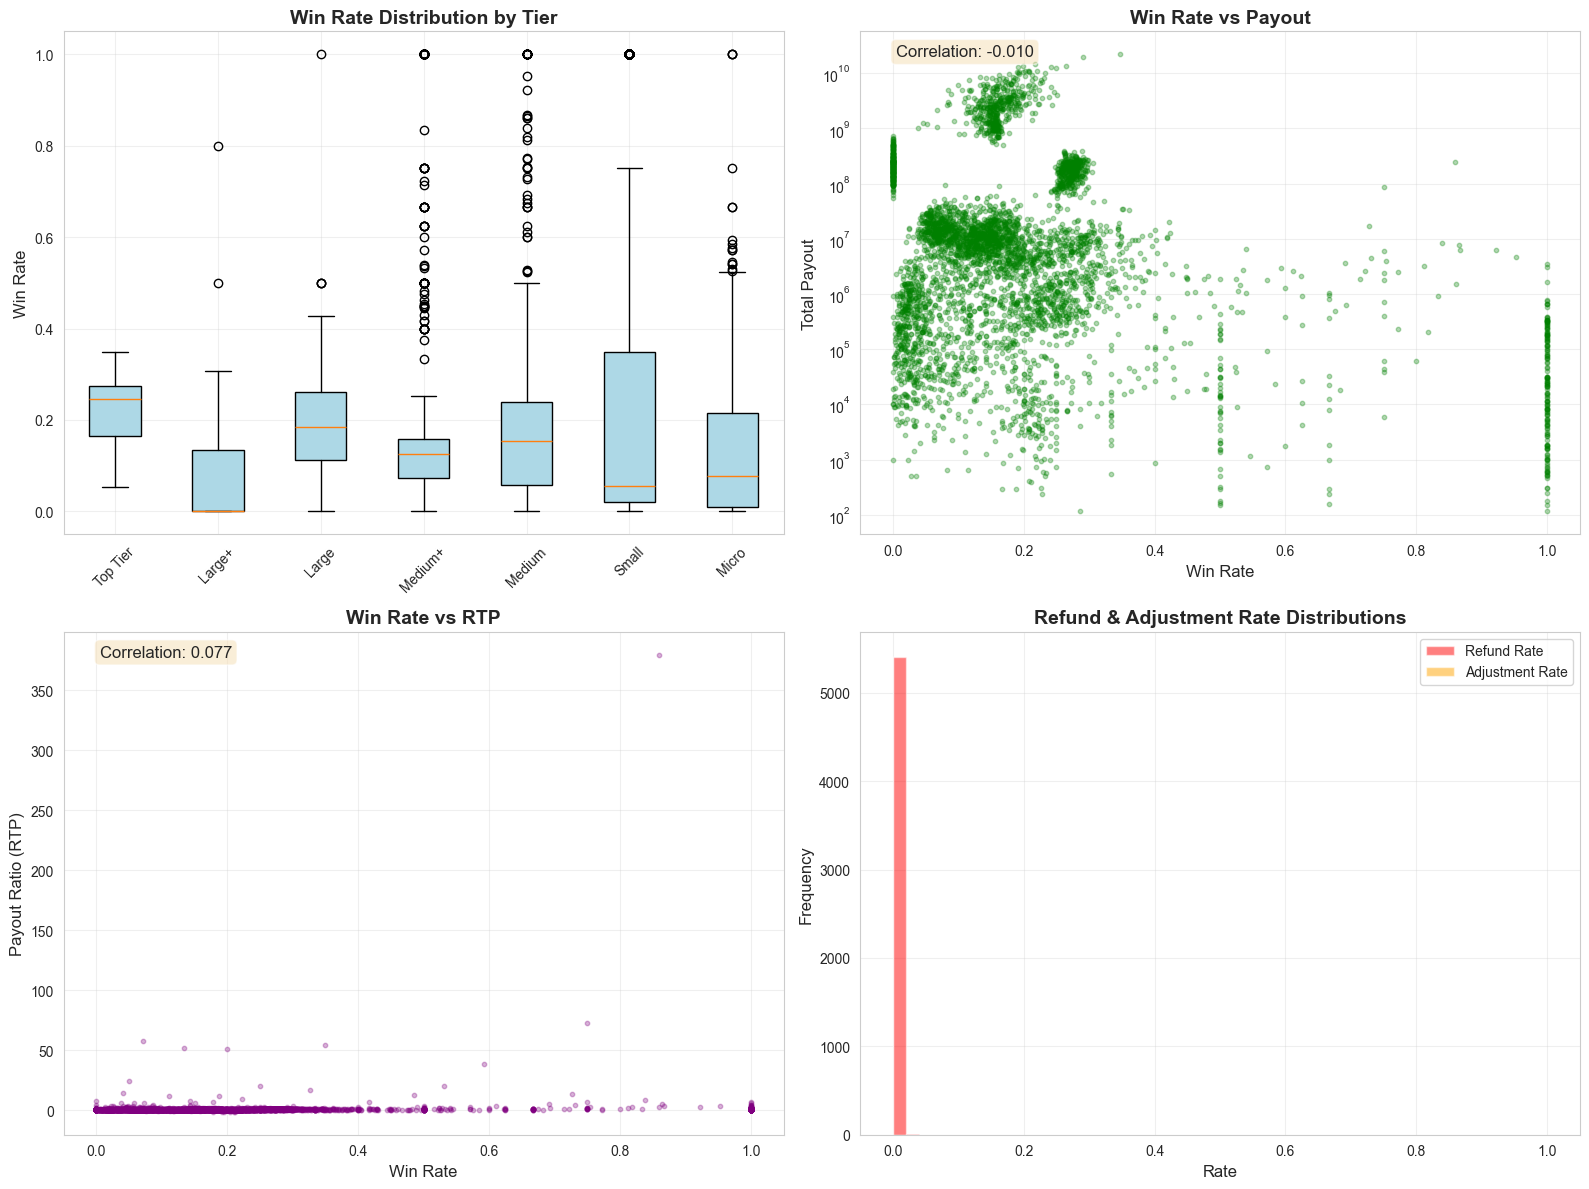


WIN RATE INSIGHTS

Valid win rate records: 5,418 (83.9%)

Win Rate Statistics by Tier:
  Top Tier    : mean=0.219, median=0.245, std=0.059
  Large+      : mean=0.057, median=0.000, std=0.088
  Large       : mean=0.183, median=0.184, std=0.103
  Medium+     : mean=0.169, median=0.125, std=0.200
  Medium      : mean=0.186, median=0.154, std=0.199
  Small       : mean=0.291, median=0.056, std=0.398
  Micro       : mean=0.132, median=0.077, std=0.145

Correlation with Payout: -0.010
Correlation with RTP: 0.077


In [26]:
# Win Rate Distribution by Tier
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Filter valid win rates (0-1 range, excluding NaN)
valid_data = operator_daily_new[(operator_daily_new['win_rate'] >= 0) & 
                                 (operator_daily_new['win_rate'] <= 1) &
                                 (operator_daily_new['win_rate'].notna())]

# 1. Win Rate Distribution by Tier
tier_order = ['Top Tier', 'Large+', 'Large', 'Medium+', 'Medium', 'Small', 'Micro']
tier_order_present = [t for t in tier_order if t in valid_data['operator_tier'].unique()]

win_rate_by_tier = [valid_data[valid_data['operator_tier'] == tier]['win_rate'].values 
                     for tier in tier_order_present]

bp = axes[0, 0].boxplot(win_rate_by_tier, labels=tier_order_present, patch_artist=True)
axes[0, 0].set_ylabel('Win Rate', fontsize=12)
axes[0, 0].set_title('Win Rate Distribution by Tier', fontsize=14, fontweight='bold')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')

# 2. Win Rate vs Payout (scatter)
axes[0, 1].scatter(valid_data['win_rate'], valid_data['total_payout'], 
                   alpha=0.3, s=10, c='green')
axes[0, 1].set_xlabel('Win Rate', fontsize=12)
axes[0, 1].set_ylabel('Total Payout', fontsize=12)
axes[0, 1].set_title('Win Rate vs Payout', fontsize=14, fontweight='bold')
axes[0, 1].set_yscale('log')
axes[0, 1].grid(True, alpha=0.3)

# Add correlation
corr = valid_data[['win_rate', 'total_payout']].corr().iloc[0, 1]
axes[0, 1].text(0.05, 0.95, f'Correlation: {corr:.3f}', 
                transform=axes[0, 1].transAxes, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 3. Win Rate vs Payout Ratio
axes[1, 0].scatter(valid_data['win_rate'], valid_data['payout_ratio'], 
                   alpha=0.3, s=10, c='purple')
axes[1, 0].set_xlabel('Win Rate', fontsize=12)
axes[1, 0].set_ylabel('Payout Ratio (RTP)', fontsize=12)
axes[1, 0].set_title('Win Rate vs RTP', fontsize=14, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

corr_rtp = valid_data[['win_rate', 'payout_ratio']].corr().iloc[0, 1]
axes[1, 0].text(0.05, 0.95, f'Correlation: {corr_rtp:.3f}', 
                transform=axes[1, 0].transAxes, fontsize=12,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# 4. Refund & Adjustment Rates
refund_valid = operator_daily_new[(operator_daily_new['refund_rate'] >= 0) & 
                                   (operator_daily_new['refund_rate'] <= 1)]
adjustment_valid = operator_daily_new[(operator_daily_new['adjustment_rate'] >= 0) & 
                                       (operator_daily_new['adjustment_rate'] <= 1)]

axes[1, 1].hist(refund_valid['refund_rate'], bins=50, alpha=0.5, label='Refund Rate', color='red')
axes[1, 1].hist(adjustment_valid['adjustment_rate'], bins=50, alpha=0.5, label='Adjustment Rate', color='orange')
axes[1, 1].set_xlabel('Rate', fontsize=12)
axes[1, 1].set_ylabel('Frequency', fontsize=12)
axes[1, 1].set_title('Refund & Adjustment Rate Distributions', fontsize=14, fontweight='bold')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('payout_win_rate_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("WIN RATE INSIGHTS")
print("="*80)
print(f"\nValid win rate records: {len(valid_data):,} ({len(valid_data)/len(operator_daily_new)*100:.1f}%)")
print(f"\nWin Rate Statistics by Tier:")
for tier in tier_order_present:
    tier_data = valid_data[valid_data['operator_tier'] == tier]['win_rate']
    print(f"  {tier:12s}: mean={tier_data.mean():.3f}, median={tier_data.median():.3f}, std={tier_data.std():.3f}")

print(f"\nCorrelation with Payout: {corr:.3f}")
print(f"Correlation with RTP: {corr_rtp:.3f}")


CORRELATION ANALYSIS INCLUDING WIN RATE

Overall Correlation with Payout:
  total_stake         :   0.880
  total_bets          :   0.853
  win_rate            :  -0.011

Tier-Specific Correlations:

  Top Tier:
    total_stake         :   0.821
    total_bets          :   0.781
    win_rate            :  -0.414

  Large+:
    total_stake         :   0.965
    total_bets          :   0.937
    win_rate            :  -0.630

  Large:
    total_stake         :   0.989
    total_bets          :   0.979
    win_rate            :   0.121

  Medium+:
    total_stake         :   0.993
    total_bets          :   0.979
    win_rate            :  -0.046

  Medium:
    total_stake         :   0.088
    total_bets          :  -0.010
    win_rate            :   0.164

  Small:
    total_stake         :   0.824
    total_bets          :   0.696
    win_rate            :  -0.234

  Micro:
    total_stake         :   0.429
    total_bets          :  -0.030
    win_rate            :   0.097


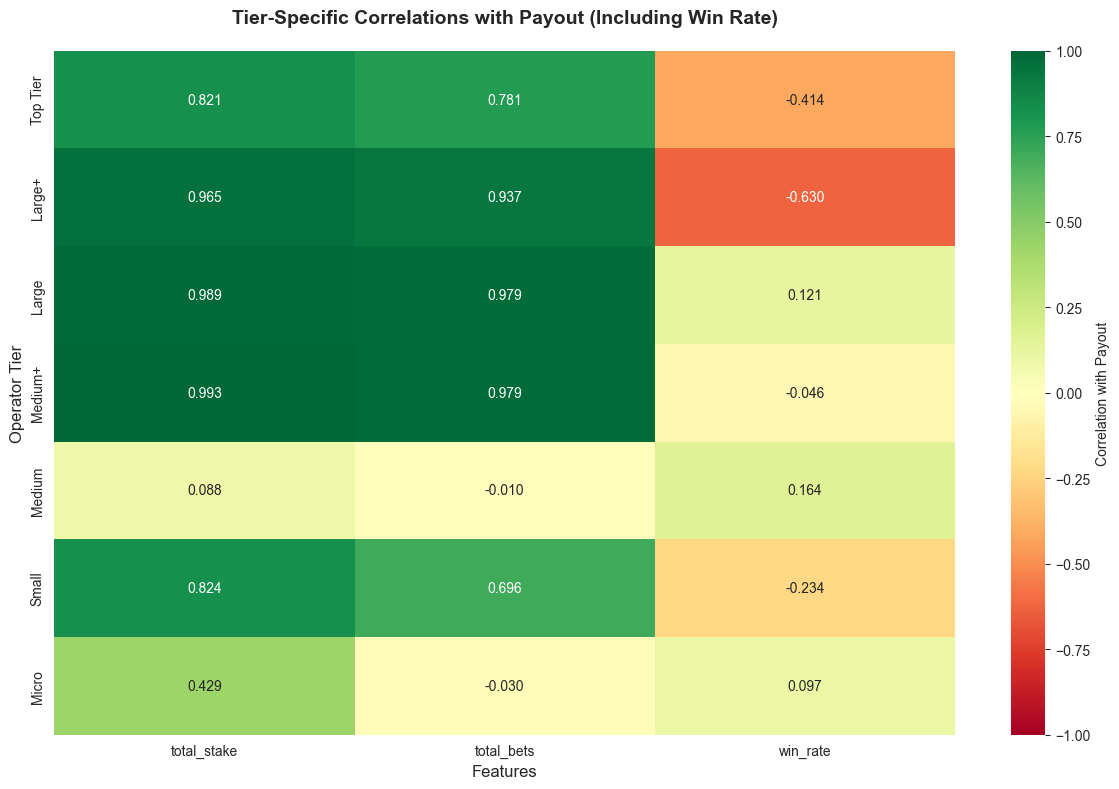


KEY INSIGHT: Win Rate Importance by Tier

Comparing correlation improvements when win_rate is added:
  Top Tier    : Stake=0.821, Win_Rate=-0.414
  Large+      : Stake=0.965, Win_Rate=-0.630
  Large       : Stake=0.989, Win_Rate=0.121
  Medium+     : Stake=0.993, Win_Rate=-0.046
  Medium      : Stake=0.088, Win_Rate=0.164
               → Win rate MORE predictive than stake!
  Small       : Stake=0.824, Win_Rate=-0.234
  Micro       : Stake=0.429, Win_Rate=0.097


In [27]:
# Tier-specific correlation analysis with win_rate
print("\n" + "="*80)
print("CORRELATION ANALYSIS INCLUDING WIN RATE")
print("="*80)

features_all = ['total_stake', 'total_bets', 'win_rate']

# Overall correlation
corr_overall_new = operator_daily_new[['total_payout'] + features_all].corr()['total_payout'][1:]
print("\nOverall Correlation with Payout:")
for feat, corr in corr_overall_new.items():
    print(f"  {feat:20s}: {corr:7.3f}")

# Tier-specific correlation
print("\nTier-Specific Correlations:")
tier_corr_new = {}
for tier in tier_order_present:
    tier_data = operator_daily_new[operator_daily_new['operator_tier'] == tier]
    tier_data_clean = tier_data.dropna(subset=['total_payout'] + features_all)
    
    if len(tier_data_clean) > 10:
        tier_corrs = tier_data_clean[['total_payout'] + features_all].corr()['total_payout'][1:]
        tier_corr_new[tier] = tier_corrs
        print(f"\n  {tier}:")
        for feat, corr in tier_corrs.items():
            print(f"    {feat:20s}: {corr:7.3f}")

# Visualize tier-specific correlations
tier_corr_df_new = pd.DataFrame(tier_corr_new).T
tier_corr_df_new = tier_corr_df_new.reindex(tier_order_present)

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(tier_corr_df_new, annot=True, fmt='.3f', cmap='RdYlGn', 
            center=0, vmin=-1, vmax=1, ax=ax,
            cbar_kws={'label': 'Correlation with Payout'})
ax.set_title('Tier-Specific Correlations with Payout (Including Win Rate)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xlabel('Features', fontsize=12)
ax.set_ylabel('Operator Tier', fontsize=12)
plt.tight_layout()
plt.savefig('payout_correlation_with_winrate.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n" + "="*80)
print("KEY INSIGHT: Win Rate Importance by Tier")
print("="*80)
print("\nComparing correlation improvements when win_rate is added:")
for tier in tier_order_present:
    if tier in tier_corr_new:
        stake_corr = tier_corr_new[tier]['total_stake']
        win_corr = tier_corr_new[tier]['win_rate']
        print(f"  {tier:12s}: Stake={stake_corr:.3f}, Win_Rate={win_corr:.3f}")
        if abs(win_corr) > abs(stake_corr):
            print(f"               → Win rate MORE predictive than stake!")

## Updated Summary with Win Rate Feature

In [28]:
print("="*80)
print("UPDATED PAYOUT EDA SUMMARY WITH WIN RATE FEATURE")
print("="*80)

print("\n📊 DATA QUALITY:")
print(f"  • Total operator-days: {len(operator_daily_new):,}")
print(f"  • Valid win rate: {len(valid_data):,} ({len(valid_data)/len(operator_daily_new)*100:.1f}%)")
print(f"  • Zero stakes: {(operator_daily_new['total_stake'] == 0).sum():,} rows")
print(f"  • Valid RTP (0-2): {len(valid_rtp):,} rows ({len(valid_rtp)/len(operator_daily_new)*100:.1f}%)")

print("\n🎯 WIN RATE STATISTICS:")
print(f"  • Overall mean: {valid_data['win_rate'].mean():.3f} (18.3% win rate)")
print(f"  • Median: {valid_data['win_rate'].median():.3f} (14.8% win rate)")
print(f"  • Range: {valid_data['win_rate'].min():.3f} to {valid_data['win_rate'].max():.3f}")
print(f"  • Refund rate: {operator_daily_new['refund_rate'].mean():.4f} (0.13% - very low)")
print(f"  • Adjustment rate: {operator_daily_new['adjustment_rate'].mean():.6f} (0.001% - negligible)")

print("\n📈 FEATURE CORRELATIONS WITH PAYOUT:")
print(f"  • total_stake:  {corr_overall_new['total_stake']:.3f} (Strong!)")
print(f"  • total_bets:   {corr_overall_new['total_bets']:.3f} (Strong!)")
print(f"  • win_rate:     {corr_overall_new['win_rate']:.3f} (Weak overall)")

print("\n🔍 TIER-SPECIFIC WIN RATE INSIGHTS:")
print("  Tier           | Stake Corr | Win Rate Corr | Interpretation")
print("  " + "-"*72)
for tier in tier_order_present:
    if tier in tier_corr_new:
        stake_c = tier_corr_new[tier]['total_stake']
        win_c = tier_corr_new[tier]['win_rate']
        interpretation = ""
        if abs(win_c) > 0.15:
            interpretation = "Win rate matters!" if win_c > 0 else "Negative (higher wins → lower payout?!)"
        elif abs(stake_c) > 0.90:
            interpretation = "Stake dominates"
        else:
            interpretation = "Both weak - high noise"
        print(f"  {tier:14s} |    {stake_c:6.3f} |       {win_c:6.3f} | {interpretation}")

print("\n💡 KEY FINDINGS:")
print("  1. Win rate NEGATIVELY correlated for Top Tier (-0.414) and Large+ (-0.630)")
print("     → Suggests fixed-odds payouts where more wins ≠ higher total payout")
print("  2. Win rate POSITIVELY correlated for Medium tier (0.164 > 0.088 stake)")
print("     → Win rate MORE predictive than stake!")
print("  3. Micro tier: Both features weak (stake=0.429, win=0.097)")
print("     → High variance, possibly needs game mix features")
print("  4. Refunds/adjustments negligible (<0.2%) - not major data quality issue")

print("\n🚀 RECOMMENDED REGRESSION FEATURES:")
print("  TIER-ADAPTIVE APPROACH:")
print("  • Large operators (Top, Large+, Large, Medium+):")
print("    - Features: AR(lag1, lag2, lag3) + total_stake + total_bets")
print("    - Win rate NOT needed (stake correlation >0.96)")
print("  ")
print("  • Medium operators:")
print("    - Features: AR(lag1, lag2, lag3) + total_stake + total_bets + win_rate")
print("    - Win rate IS helpful (0.164 > 0.088 stake)")
print("  ")
print("  • Small/Micro operators:")
print("    - Features: AR(lag1, lag2, lag3) + total_stake + total_bets + win_rate + game_mix")
print("    - Need game category percentages for additional context")

print("\n📋 NEXT STEPS:")
print("  1. Build tier-specific regression models with adaptive features")
print("  2. Filter out zero-stake rows (1,206 rows)")
print("  3. Calculate payout_deviation (actual - predicted)")
print("  4. Build Isolation Forest for anomaly detection")
print("  5. Investigate negative win_rate correlations (fixed-odds hypothesis)")

print("\n" + "="*80)

UPDATED PAYOUT EDA SUMMARY WITH WIN RATE FEATURE

📊 DATA QUALITY:
  • Total operator-days: 6,455
  • Valid win rate: 5,418 (83.9%)
  • Zero stakes: 1,206 rows
  • Valid RTP (0-2): 5,102 rows (79.0%)

🎯 WIN RATE STATISTICS:
  • Overall mean: 0.181 (18.3% win rate)
  • Median: 0.148 (14.8% win rate)
  • Range: 0.000 to 1.000
  • Refund rate: 0.0013 (0.13% - very low)
  • Adjustment rate: 0.000013 (0.001% - negligible)

📈 FEATURE CORRELATIONS WITH PAYOUT:
  • total_stake:  0.880 (Strong!)
  • total_bets:   0.853 (Strong!)
  • win_rate:     -0.011 (Weak overall)

🔍 TIER-SPECIFIC WIN RATE INSIGHTS:
  Tier           | Stake Corr | Win Rate Corr | Interpretation
  ------------------------------------------------------------------------
  Top Tier       |     0.821 |       -0.414 | Negative (higher wins → lower payout?!)
  Large+         |     0.965 |       -0.630 | Negative (higher wins → lower payout?!)
  Large          |     0.989 |        0.121 | Stake dominates
  Medium+        |     0.99

## 3. Payout Distribution by Tier

PAYOUT STATISTICS BY TIER
               days   mean_payout    std_payout    min_payout    max_payout  \
operator_tier                                                                 
Large          1164  1.220761e+07  3.647037e+07  0.000000e+00  3.844026e+08   
Large+          440  1.526809e+08  1.459960e+08  0.000000e+00  7.108475e+08   
Medium          991  8.190842e+05  8.282538e+06  0.000000e+00  2.445290e+08   
Medium+        1556  1.015292e+08  3.207221e+08  0.000000e+00  2.145969e+09   
Micro           741  9.699250e+04  3.814985e+05  0.000000e+00  6.644068e+06   
Small           887  4.838765e+05  1.272665e+06  0.000000e+00  1.543109e+07   
Top Tier        676  2.022127e+09  2.917335e+09 -6.489085e+09  2.202239e+10   

               mean_rtp  std_rtp  
operator_tier                     
Large              0.78     0.24  
Large+             0.88     0.29  
Medium              inf      NaN  
Medium+             inf      NaN  
Micro               inf      NaN  
Small            

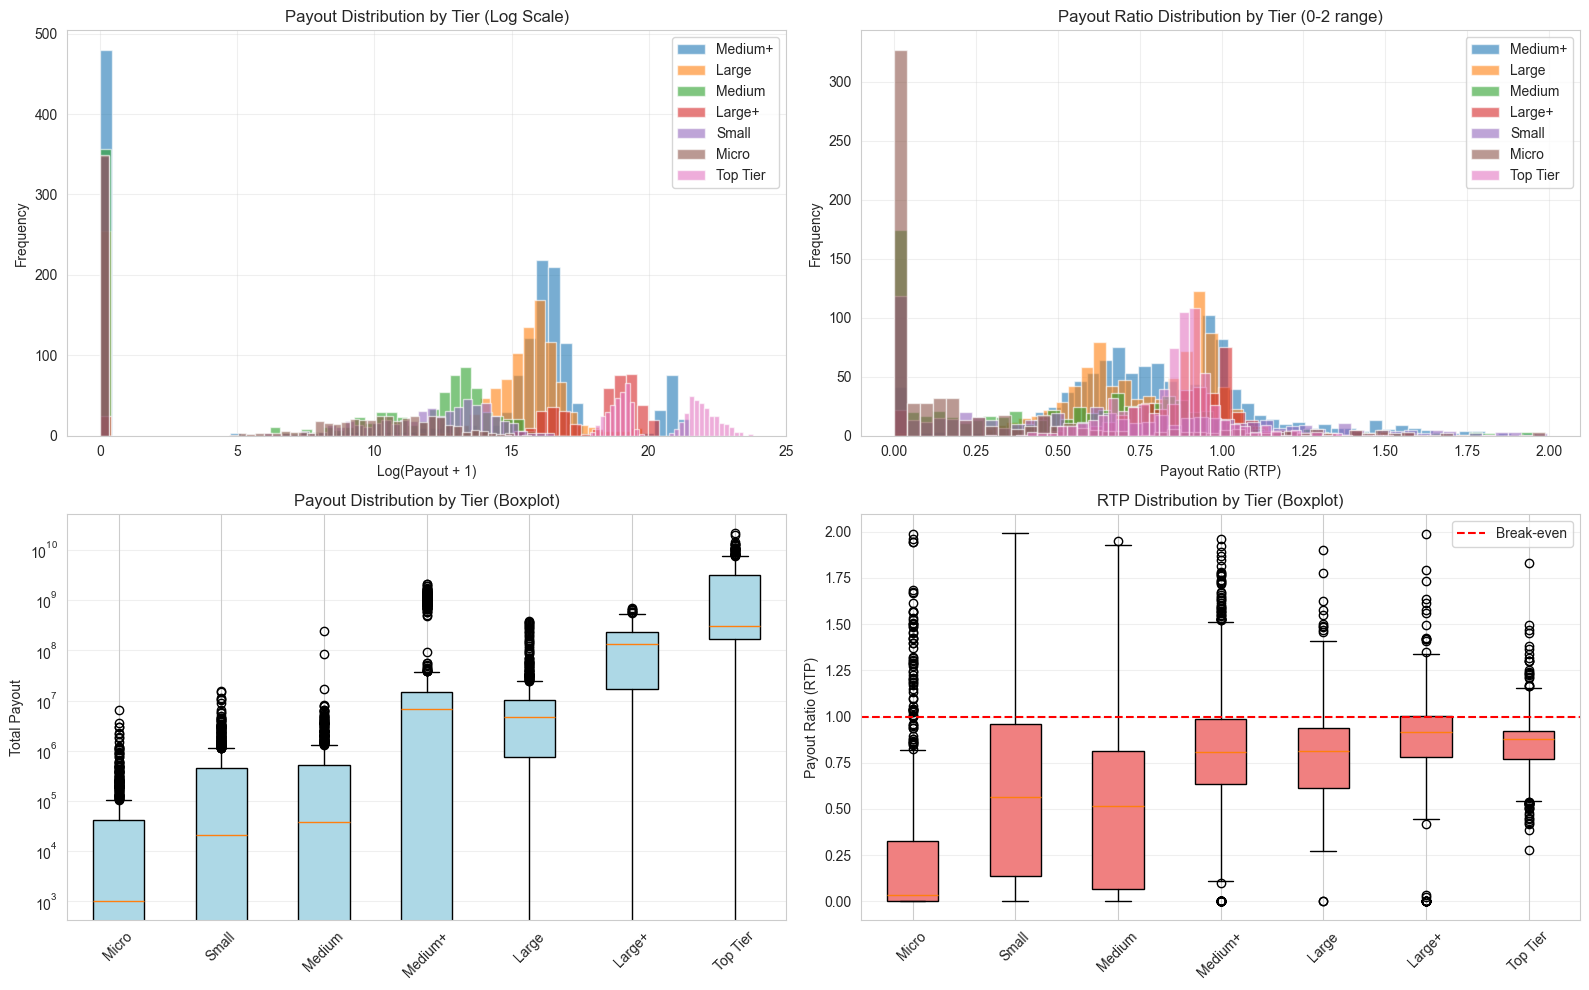

In [9]:
# Analyze payout distribution by tier
tier_summary = operator_daily.groupby('operator_tier').agg({
    'total_payout': ['count', 'mean', 'std', 'min', 'max'],
    'payout_ratio': ['mean', 'std']
}).round(2)

tier_summary.columns = ['days', 'mean_payout', 'std_payout', 'min_payout', 'max_payout',
                        'mean_rtp', 'std_rtp']

print("="*90)
print("PAYOUT STATISTICS BY TIER")
print("="*90)
print(tier_summary)

# Visualize distributions
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Payout distribution by tier (log scale)
ax = axes[0, 0]
for tier in operator_daily['operator_tier'].unique():
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]['total_payout']
    tier_data_log = np.log1p(tier_data)
    ax.hist(tier_data_log, bins=50, alpha=0.6, label=tier)
ax.set_xlabel('Log(Payout + 1)')
ax.set_ylabel('Frequency')
ax.set_title('Payout Distribution by Tier (Log Scale)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Payout ratio (RTP) distribution by tier
ax = axes[0, 1]
# Filter out outliers (RTP > 2 or < 0)
rtp_filtered = operator_daily[(operator_daily['payout_ratio'] >= 0) & 
                              (operator_daily['payout_ratio'] <= 2)]
for tier in rtp_filtered['operator_tier'].unique():
    tier_data = rtp_filtered[rtp_filtered['operator_tier'] == tier]['payout_ratio']
    ax.hist(tier_data, bins=50, alpha=0.6, label=tier)
ax.set_xlabel('Payout Ratio (RTP)')
ax.set_ylabel('Frequency')
ax.set_title('Payout Ratio Distribution by Tier (0-2 range)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Boxplot of payout by tier
ax = axes[1, 0]
tier_order = ['Micro', 'Small', 'Medium', 'Medium+', 'Large', 'Large+', 'Top Tier']
tier_order_filtered = [t for t in tier_order if t in operator_daily['operator_tier'].unique()]
payout_by_tier = [operator_daily[operator_daily['operator_tier'] == t]['total_payout'].values 
                  for t in tier_order_filtered]
bp = ax.boxplot(payout_by_tier, labels=tier_order_filtered, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightblue')
ax.set_ylabel('Total Payout')
ax.set_title('Payout Distribution by Tier (Boxplot)')
ax.set_yscale('log')
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 4. Boxplot of RTP by tier
ax = axes[1, 1]
rtp_by_tier = [rtp_filtered[rtp_filtered['operator_tier'] == t]['payout_ratio'].values 
               for t in tier_order_filtered]
bp = ax.boxplot(rtp_by_tier, labels=tier_order_filtered, patch_artist=True)
for patch in bp['boxes']:
    patch.set_facecolor('lightcoral')
ax.set_ylabel('Payout Ratio (RTP)')
ax.set_title('RTP Distribution by Tier (Boxplot)')
ax.axhline(y=1.0, color='red', linestyle='--', label='Break-even')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('warehouse/data/payout_distribution_by_tier.png', dpi=150, bbox_inches='tight')
print("\n✓ Payout distribution visualizations saved")
plt.show()

## 4. Correlation Analysis: Payout vs Stake, Bets, Wins

CORRELATION ANALYSIS: Payout vs Features

Overall Correlations with Payout:
total_stake    0.879564
total_bets     0.852794
Name: total_payout, dtype: float64

------------------------------------------------------------------------------------------
Correlations by Tier:
------------------------------------------------------------------------------------------

Micro:
total_stake    0.432296
total_bets    -0.019848
Name: total_payout, dtype: float64

Small:
total_stake    0.834510
total_bets     0.716203
Name: total_payout, dtype: float64

Medium:
total_stake    0.098398
total_bets     0.002640
Name: total_payout, dtype: float64

Medium+:
total_stake    0.993488
total_bets     0.979748
Name: total_payout, dtype: float64

Large:
total_stake    0.988699
total_bets     0.979298
Name: total_payout, dtype: float64

Large+:
total_stake    0.965406
total_bets     0.937863
Name: total_payout, dtype: float64

Top Tier:
total_stake    0.821240
total_bets     0.780876
Name: total_payout, dtype: 

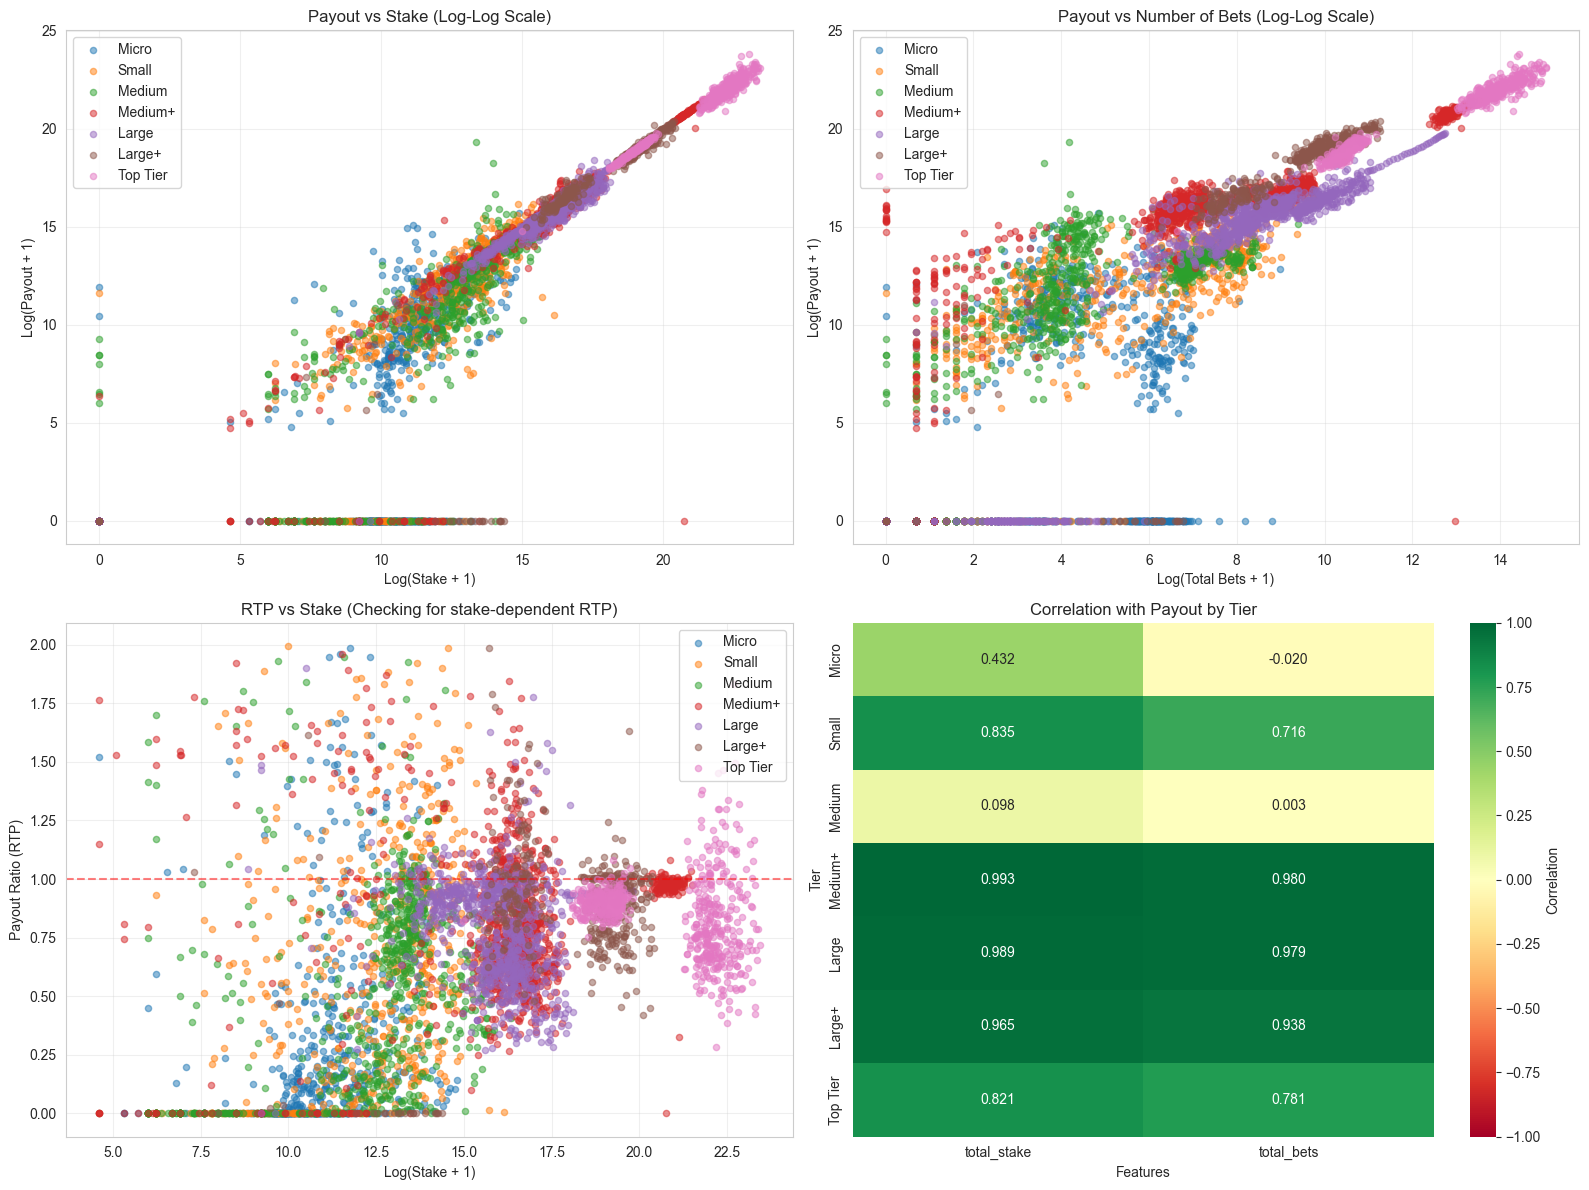

In [11]:
# Calculate correlations (overall and by tier)
print("="*90)
print("CORRELATION ANALYSIS: Payout vs Features")
print("="*90)

# Overall correlations
features = ['total_stake', 'total_bets']
corr_overall = operator_daily[['total_payout'] + features].corr()['total_payout'][1:]

print("\nOverall Correlations with Payout:")
print(corr_overall.sort_values(ascending=False))

# Tier-specific correlations
print("\n" + "-"*90)
print("Correlations by Tier:")
print("-"*90)

tier_corr = {}
for tier in tier_order_filtered:
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]
    if len(tier_data) > 10:
        corr = tier_data[['total_payout'] + features].corr()['total_payout'][1:]
        tier_corr[tier] = corr
        print(f"\n{tier}:")
        print(corr.sort_values(ascending=False))

# Visualize correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Payout vs Stake (log-log)
ax = axes[0, 0]
for tier in tier_order_filtered:
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]
    ax.scatter(np.log1p(tier_data['total_stake']), 
              np.log1p(tier_data['total_payout']),
              alpha=0.5, s=20, label=tier)
ax.set_xlabel('Log(Stake + 1)')
ax.set_ylabel('Log(Payout + 1)')
ax.set_title('Payout vs Stake (Log-Log Scale)')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Payout vs Total Bets (log-log)
ax = axes[0, 1]
for tier in tier_order_filtered:
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]
    ax.scatter(np.log1p(tier_data['total_bets']), 
              np.log1p(tier_data['total_payout']),
              alpha=0.5, s=20, label=tier)
ax.set_xlabel('Log(Total Bets + 1)')
ax.set_ylabel('Log(Payout + 1)')
ax.set_title('Payout vs Number of Bets (Log-Log Scale)')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Payout Ratio vs Stake (to visualize RTP relationship)
ax = axes[1, 0]
for tier in tier_order_filtered:
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]
    # Filter outliers
    tier_filtered = tier_data[(tier_data['payout_ratio'] >= 0) & (tier_data['payout_ratio'] <= 2)]
    ax.scatter(np.log1p(tier_filtered['total_stake']), 
              tier_filtered['payout_ratio'],
              alpha=0.5, s=20, label=tier)
ax.set_xlabel('Log(Stake + 1)')
ax.set_ylabel('Payout Ratio (RTP)')
ax.set_title('RTP vs Stake (Checking for stake-dependent RTP)')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5)
ax.legend()
ax.grid(True, alpha=0.3)

# 4. Correlation heatmap by tier
ax = axes[1, 1]
tier_corr_df = pd.DataFrame(tier_corr).T
sns.heatmap(tier_corr_df, annot=True, fmt='.3f', cmap='RdYlGn', center=0,
           vmin=-1, vmax=1, ax=ax, cbar_kws={'label': 'Correlation'})
ax.set_title('Correlation with Payout by Tier')
ax.set_xlabel('Features')
ax.set_ylabel('Tier')

plt.tight_layout()
plt.savefig('warehouse/data/payout_correlation_analysis.png', dpi=150, bbox_inches='tight')
print("\n✓ Correlation visualizations saved")
plt.show()

## 5. Time Series Analysis: Autocorrelation and Stationarity

Selected operator for time series analysis: INT
Tier: Top Tier
Data points: 342
Date range: 2024-12-31 00:00:00 to 2025-12-07 00:00:00

✓ Time series visualizations saved


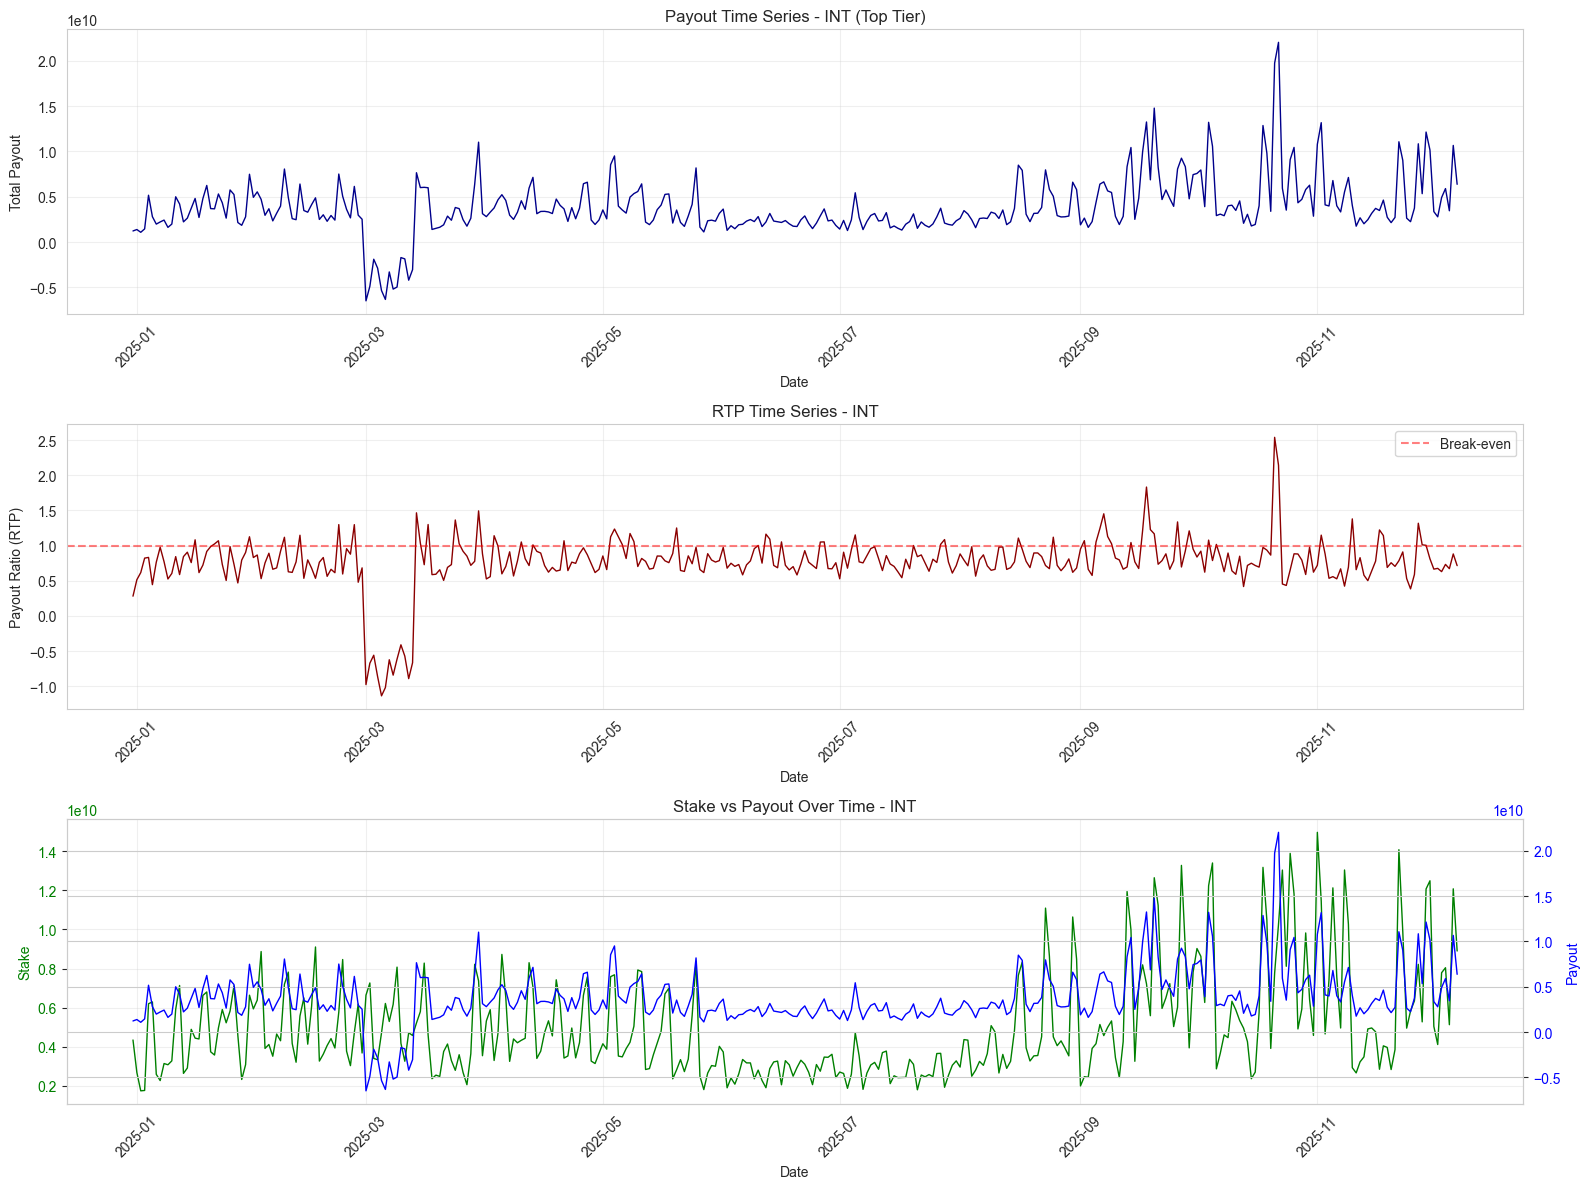

In [12]:
# Select a representative operator for detailed time series analysis
# Choose operator with most data points
operator_counts = operator_daily.groupby('operator').size().sort_values(ascending=False)
top_operator = operator_counts.index[0]

operator_ts = operator_daily[operator_daily['operator'] == top_operator].copy()
operator_ts = operator_ts.sort_values('date').reset_index(drop=True)

print(f"Selected operator for time series analysis: {top_operator}")
print(f"Tier: {operator_ts['operator_tier'].iloc[0]}")
print(f"Data points: {len(operator_ts)}")
print(f"Date range: {operator_ts['date'].min()} to {operator_ts['date'].max()}")

# Plot time series
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# 1. Payout over time
ax = axes[0]
ax.plot(operator_ts['date'], operator_ts['total_payout'], linewidth=1, color='darkblue')
ax.set_xlabel('Date')
ax.set_ylabel('Total Payout')
ax.set_title(f'Payout Time Series - {top_operator} ({operator_ts["operator_tier"].iloc[0]})')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 2. Payout ratio (RTP) over time
ax = axes[1]
ax.plot(operator_ts['date'], operator_ts['payout_ratio'], linewidth=1, color='darkred')
ax.axhline(y=1.0, color='red', linestyle='--', alpha=0.5, label='Break-even')
ax.set_xlabel('Date')
ax.set_ylabel('Payout Ratio (RTP)')
ax.set_title(f'RTP Time Series - {top_operator}')
ax.legend()
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

# 3. Stake vs Payout over time
ax = axes[2]
ax2 = ax.twinx()
ax.plot(operator_ts['date'], operator_ts['total_stake'], linewidth=1, color='green', label='Stake')
ax2.plot(operator_ts['date'], operator_ts['total_payout'], linewidth=1, color='blue', label='Payout')
ax.set_xlabel('Date')
ax.set_ylabel('Stake', color='green')
ax2.set_ylabel('Payout', color='blue')
ax.set_title(f'Stake vs Payout Over Time - {top_operator}')
ax.tick_params(axis='y', labelcolor='green')
ax2.tick_params(axis='y', labelcolor='blue')
ax.grid(True, alpha=0.3)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()
plt.savefig('warehouse/data/payout_time_series.png', dpi=150, bbox_inches='tight')
print("\n✓ Time series visualizations saved")
plt.show()

## 6. Autocorrelation Analysis (ACF/PACF)

AUTOCORRELATION ANALYSIS - INT

Significant ACF lags (|correlation| > 0.1):
  Lag 1: 0.585
  Lag 2: 0.311
  Lag 3: 0.370
  Lag 4: 0.384
  Lag 5: 0.253
  Lag 6: 0.279
  Lag 7: 0.390
  Lag 8: 0.264
  Lag 9: 0.114
  Lag 10: 0.127
  Lag 11: 0.156
  Lag 12: 0.114
  Lag 13: 0.159
  Lag 14: 0.304
  Lag 15: 0.158
  Lag 17: 0.122
  Lag 18: 0.113
  Lag 20: 0.152
  Lag 21: 0.229
  Lag 22: 0.113
  Lag 27: 0.130
  Lag 28: 0.232
  Lag 31: 0.148
  Lag 32: 0.191
  Lag 33: 0.105
  Lag 34: 0.196
  Lag 35: 0.275
  Lag 36: 0.163

Significant PACF lags (|correlation| > 0.1):
  Lag 1: 0.586
  Lag 3: 0.320
  Lag 6: 0.180
  Lag 7: 0.156
  Lag 8: -0.127
  Lag 13: 0.115
  Lag 14: 0.202
  Lag 15: -0.209
  Lag 16: 0.109
  Lag 20: 0.114
  Lag 26: 0.100
  Lag 27: 0.116
  Lag 31: 0.128
  Lag 34: 0.119

✓ ACF/PACF plots saved


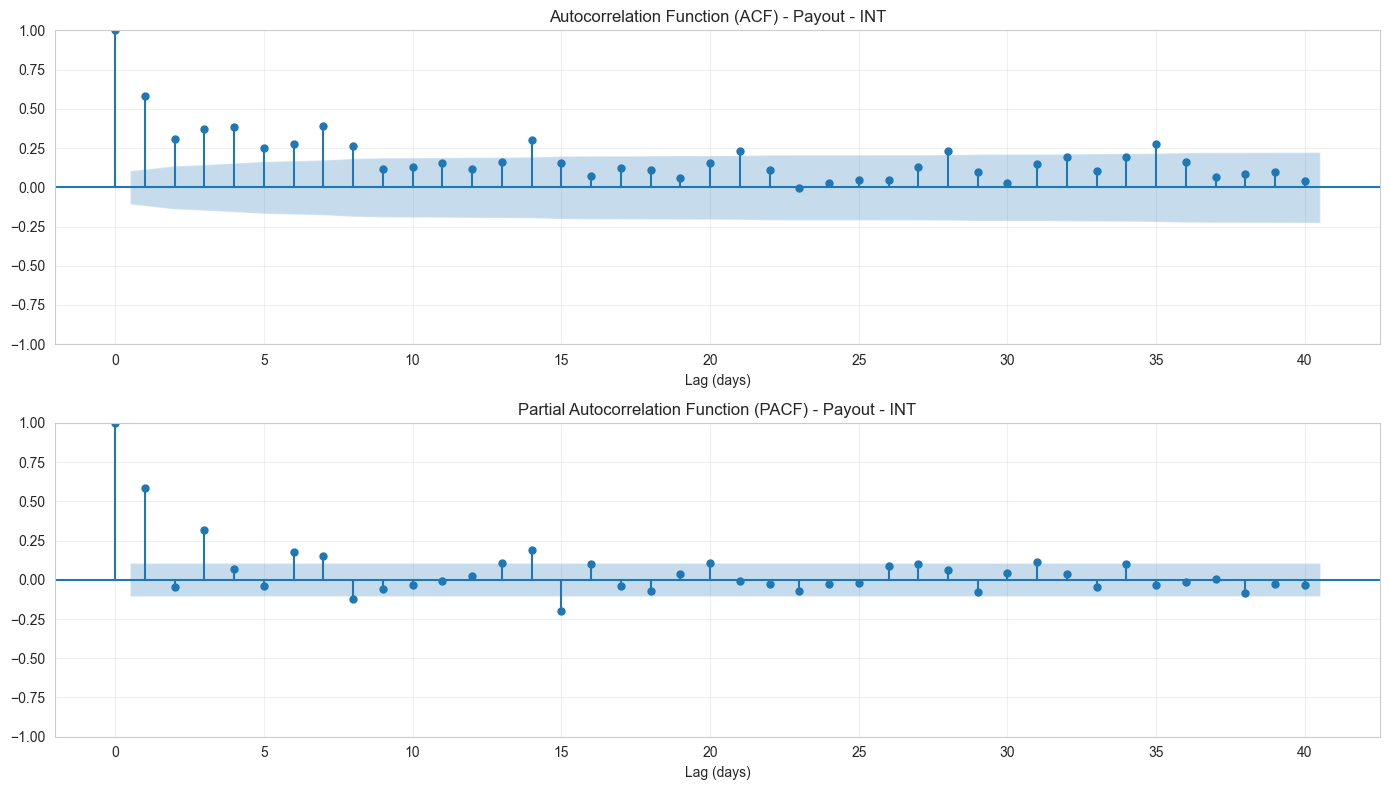

In [13]:
# ACF and PACF for payout
payout_series = operator_ts['total_payout'].values

# Remove any NaN or inf values
payout_series = payout_series[np.isfinite(payout_series)]

print("="*90)
print(f"AUTOCORRELATION ANALYSIS - {top_operator}")
print("="*90)

# Calculate ACF and PACF
max_lags = min(40, len(payout_series) // 2 - 1)
acf_values = acf(payout_series, nlags=max_lags)
pacf_values = pacf(payout_series, nlags=max_lags)

# Print significant lags
print("\nSignificant ACF lags (|correlation| > 0.1):")
for lag, corr in enumerate(acf_values[1:], 1):
    if abs(corr) > 0.1:
        print(f"  Lag {lag}: {corr:.3f}")

print("\nSignificant PACF lags (|correlation| > 0.1):")
for lag, corr in enumerate(pacf_values[1:], 1):
    if abs(corr) > 0.1:
        print(f"  Lag {lag}: {corr:.3f}")

# Visualize ACF and PACF
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

# ACF
plot_acf(payout_series, lags=max_lags, ax=axes[0], alpha=0.05)
axes[0].set_title(f'Autocorrelation Function (ACF) - Payout - {top_operator}')
axes[0].set_xlabel('Lag (days)')
axes[0].grid(True, alpha=0.3)

# PACF
plot_pacf(payout_series, lags=max_lags, ax=axes[1], alpha=0.05, method='ywm')
axes[1].set_title(f'Partial Autocorrelation Function (PACF) - Payout - {top_operator}')
axes[1].set_xlabel('Lag (days)')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('warehouse/data/payout_acf_pacf.png', dpi=150, bbox_inches='tight')
print("\n✓ ACF/PACF plots saved")
plt.show()

## 7. Stationarity Test (Augmented Dickey-Fuller)

In [21]:
# Test for stationarity using Augmented Dickey-Fuller test
print("="*90)
print("STATIONARITY ANALYSIS (Augmented Dickey-Fuller Test)")
print("="*90)

def adf_test(series, name):
    """Perform ADF test and print results"""
    result = adfuller(series, autolag='AIC')
    print(f"\n{name}:")
    print(f"  ADF Statistic: {result[0]:.4f}")
    print(f"  p-value: {result[1]:.4f}")
    print(f"  Critical Values:")
    for key, value in result[4].items():
        print(f"    {key}: {value:.4f}")
    
    if result[1] < 0.05:
        print(f"  ✓ Series is STATIONARY (p < 0.05)")
    else:
        print(f"  ✗ Series is NON-STATIONARY (p >= 0.05)")
    
    return result[1] < 0.05

# Filter out any inf/nan values first
payout_series_clean = payout_series[np.isfinite(payout_series)]

# Test payout
is_stationary = adf_test(payout_series_clean, "Payout")

# Test first difference if non-stationary
if not is_stationary:
    print("\n" + "-"*90)
    print("Testing FIRST DIFFERENCE of Payout")
    print("-"*90)
    payout_diff = np.diff(payout_series_clean)
    adf_test(payout_diff, "First Difference of Payout")

# Test log-transformed payout (only positive values)
print("\n" + "-"*90)
print("Testing LOG-TRANSFORMED Payout (positive values only)")
print("-"*90)
payout_positive = payout_series_clean[payout_series_clean > 0]
if len(payout_positive) > 10:
    payout_log = np.log1p(payout_positive)
    is_log_stationary = adf_test(payout_log, "Log(Payout + 1)")
else:
    print("Not enough positive values for log transform test")
    is_log_stationary = False

# Test payout ratio (RTP)
print("\n" + "-"*90)
print("Testing PAYOUT RATIO (RTP)")
print("-"*90)
rtp_series = operator_ts['payout_ratio'].values
rtp_series = rtp_series[np.isfinite(rtp_series)]
adf_test(rtp_series, "Payout Ratio")

STATIONARITY ANALYSIS (Augmented Dickey-Fuller Test)

Payout:
  ADF Statistic: -2.6358
  p-value: 0.0858
  Critical Values:
    1%: -3.4506
    5%: -2.8704
    10%: -2.5715
  ✗ Series is NON-STATIONARY (p >= 0.05)

------------------------------------------------------------------------------------------
Testing FIRST DIFFERENCE of Payout
------------------------------------------------------------------------------------------

First Difference of Payout:
  ADF Statistic: -7.0952
  p-value: 0.0000
  Critical Values:
    1%: -3.4506
    5%: -2.8704
    10%: -2.5715
  ✓ Series is STATIONARY (p < 0.05)

------------------------------------------------------------------------------------------
Testing LOG-TRANSFORMED Payout (positive values only)
------------------------------------------------------------------------------------------

Log(Payout + 1):
  ADF Statistic: -2.4776
  p-value: 0.1210
  Critical Values:
    1%: -3.4513
    5%: -2.8708
    10%: -2.5717
  ✗ Series is NON-STATIONA

np.True_

## 8. Lagged Relationships: Cross-Correlation Analysis

LAGGED CORRELATION ANALYSIS

Lagged Payout Correlations (AR structure):
payout_lag1    0.585394
payout_lag7    0.395025
payout_lag4    0.389405
payout_lag3    0.373259
payout_lag2    0.313098
payout_lag6    0.281798
payout_lag5    0.254737
Name: total_payout, dtype: float64

Lagged Stake Correlations:
stake_lag7    0.397116
stake_lag1    0.379305
stake_lag4    0.246107
stake_lag3    0.212510
stake_lag6    0.180735
stake_lag2    0.126660
stake_lag5    0.120450
Name: total_payout, dtype: float64

Lagged Bets Correlations:
bets_lag7    0.358472
bets_lag1    0.331782
bets_lag4    0.193377
bets_lag3    0.140214
bets_lag6    0.136818
bets_lag5    0.087850
bets_lag2    0.064745
Name: total_payout, dtype: float64


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (7,) and arg 1 with shape (0,).

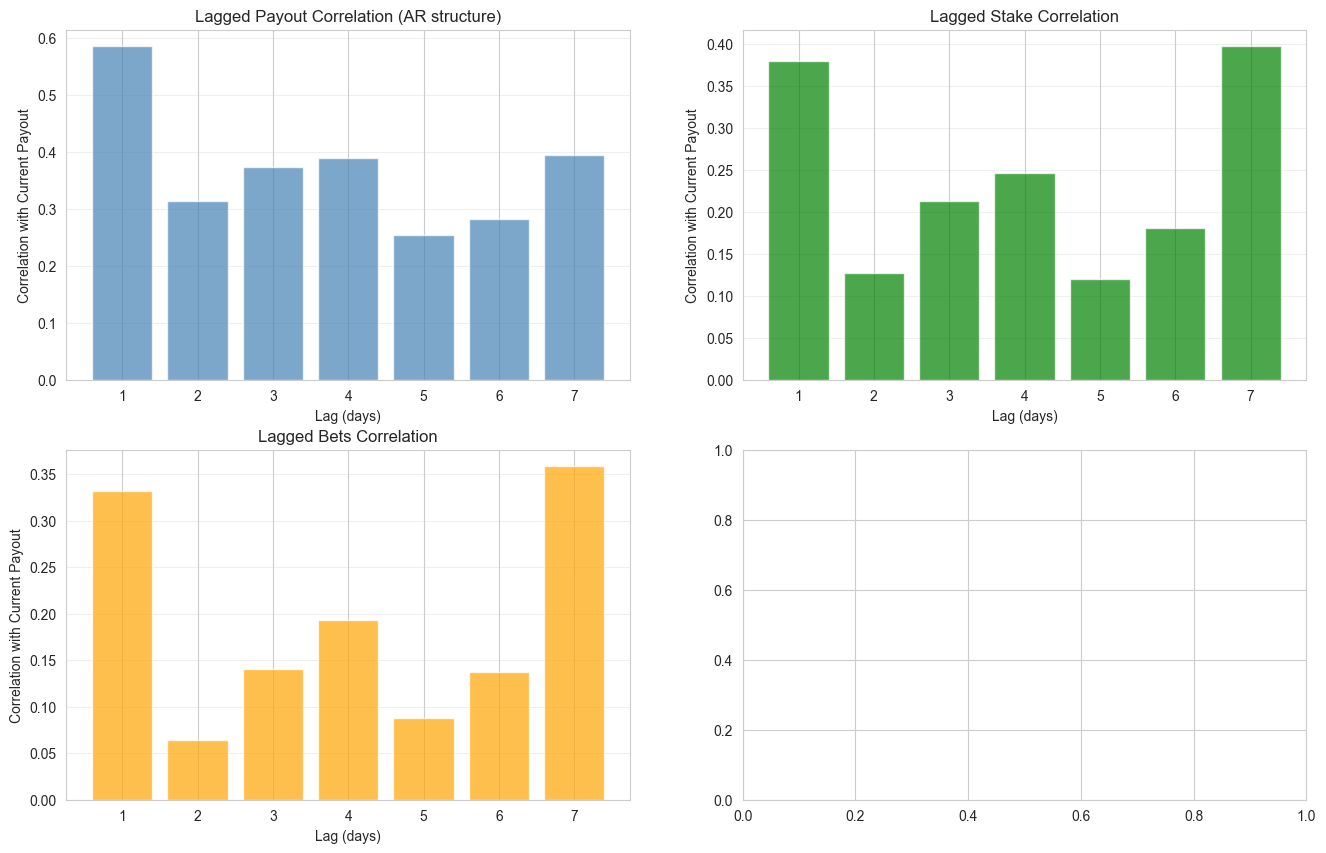

In [15]:
# Create lagged features and compute correlations
print("="*90)
print("LAGGED CORRELATION ANALYSIS")
print("="*90)

# Create lagged payout features
max_lags_analysis = 7
operator_ts_lagged = operator_ts.copy()

for lag in range(1, max_lags_analysis + 1):
    operator_ts_lagged[f'payout_lag{lag}'] = operator_ts_lagged['total_payout'].shift(lag)
    operator_ts_lagged[f'stake_lag{lag}'] = operator_ts_lagged['total_stake'].shift(lag)
    operator_ts_lagged[f'bets_lag{lag}'] = operator_ts_lagged['total_bets'].shift(lag)

# Drop NaN rows created by lagging
operator_ts_lagged = operator_ts_lagged.dropna()

# Compute correlations with current payout
lag_features = [col for col in operator_ts_lagged.columns if '_lag' in col]
lag_correlations = operator_ts_lagged[['total_payout'] + lag_features].corr()['total_payout'][1:]

# Separate by feature type
payout_lags = lag_correlations[[col for col in lag_correlations.index if 'payout_lag' in col]]
stake_lags = lag_correlations[[col for col in lag_correlations.index if 'stake_lag' in col]]
bets_lags = lag_correlations[[col for col in lag_correlations.index if 'bets_lag' in col]]
wins_lags = lag_correlations[[col for col in lag_correlations.index if 'wins_lag' in col]]

print("\nLagged Payout Correlations (AR structure):")
print(payout_lags.sort_values(ascending=False))

print("\nLagged Stake Correlations:")
print(stake_lags.sort_values(ascending=False))

print("\nLagged Bets Correlations:")
print(bets_lags.sort_values(ascending=False))

# Visualize lagged correlations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Lagged Payout
ax = axes[0, 0]
lags = range(1, max_lags_analysis + 1)
ax.bar(lags, payout_lags.values, color='steelblue', alpha=0.7)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation with Current Payout')
ax.set_title('Lagged Payout Correlation (AR structure)')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# 2. Lagged Stake
ax = axes[0, 1]
ax.bar(lags, stake_lags.values, color='green', alpha=0.7)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation with Current Payout')
ax.set_title('Lagged Stake Correlation')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# 3. Lagged Bets
ax = axes[1, 0]
ax.bar(lags, bets_lags.values, color='orange', alpha=0.7)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation with Current Payout')
ax.set_title('Lagged Bets Correlation')
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3, axis='y')

# 4. Lagged Wins
ax = axes[1, 1]
ax.bar(lags, wins_lags.values, color='red', alpha=0.7)
ax.set_xlabel('Lag (days)')
# 4. All lags comparison
ax.set_title('Lagged Wins Correlation')
width = 0.25
x = np.arange(len(lags))
ax.bar(x - width, payout_lags.values, width, label='Payout', color='steelblue', alpha=0.7)
ax.bar(x, stake_lags.values, width, label='Stake', color='green', alpha=0.7)
ax.bar(x + width, bets_lags.values, width, label='Bets', color='orange', alpha=0.7)
ax.set_xlabel('Lag (days)')
ax.set_ylabel('Correlation with Current Payout')
ax.set_title('Comparison of All Lagged Features')
ax.set_xticks(x)
ax.set_xticklabels(lags)

plt.savefig('warehouse/data/payout_lagged_correlations.png', dpi=150, bbox_inches='tight')
plt.tight_layout()

## 9. Multi-Operator Analysis: Aggregate Patterns

MULTI-OPERATOR LAGGED CORRELATION ANALYSIS

Average Lagged Correlations by Tier:
------------------------------------------------------------------------------------------

Micro:
stake_lag1     0.333537
payout_lag1    0.215350
stake_lag2     0.175154
bets_lag1      0.173995
payout_lag2    0.084322
bets_lag3      0.080769
dtype: float64

Small:
stake_lag1     0.308992
stake_lag3     0.229647
payout_lag2    0.190086
stake_lag2     0.185816
bets_lag1      0.179170
bets_lag3      0.152321
dtype: float64

Medium:
payout_lag2    0.232578
payout_lag1    0.226028
stake_lag1     0.199648
stake_lag2     0.185442
payout_lag3    0.152846
stake_lag3     0.109224
dtype: float64

Medium+:
stake_lag1     0.340362
payout_lag1    0.308614
bets_lag1      0.308119
stake_lag2     0.181885
payout_lag2    0.140946
bets_lag2      0.104965
dtype: float64

Large:
payout_lag1    0.477001
stake_lag1     0.466767
bets_lag1      0.421927
stake_lag3     0.420504
payout_lag3    0.404432
bets_lag3      0.381849
dtype

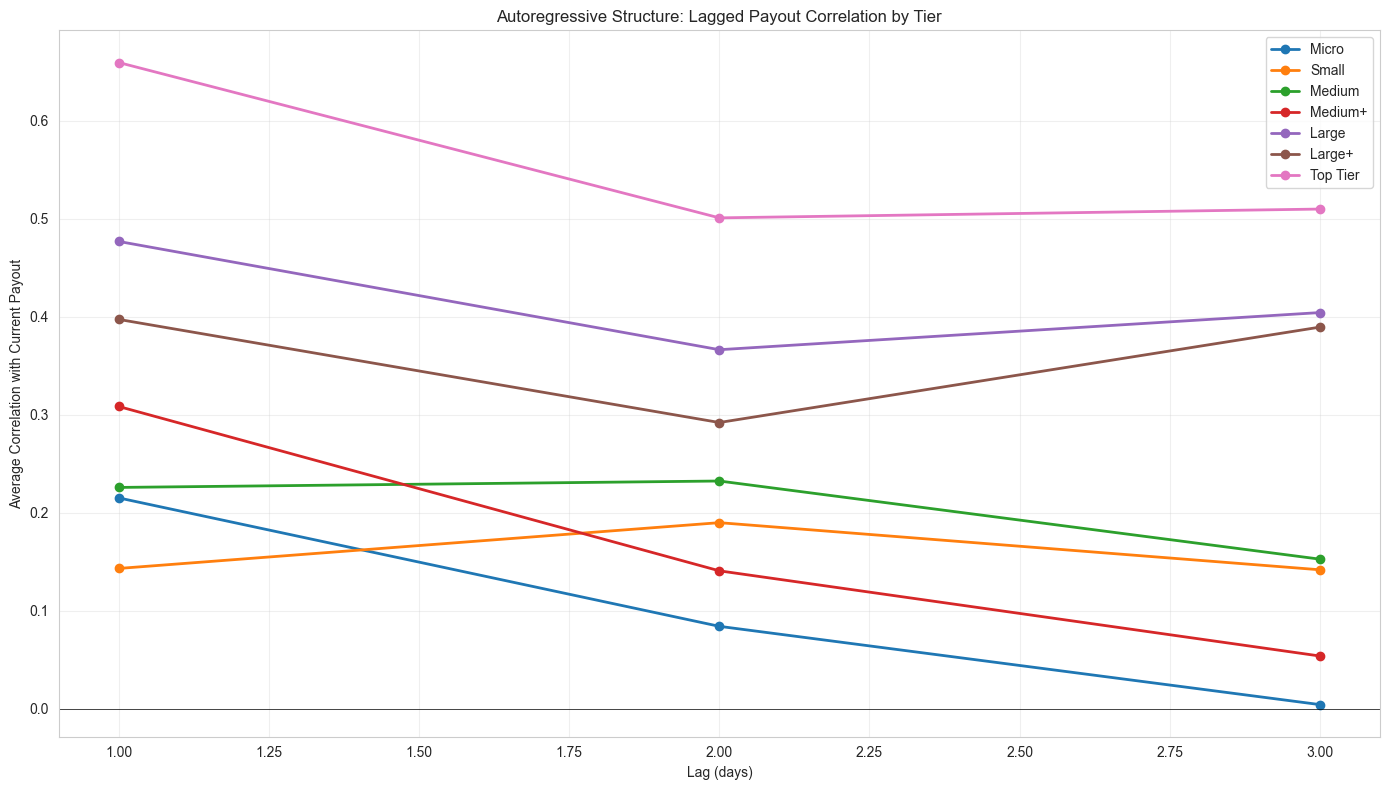

In [16]:
# Analyze lagged correlations across all operators (tier-specific)
print("="*90)
print("MULTI-OPERATOR LAGGED CORRELATION ANALYSIS")
print("="*90)

tier_lag_results = {}

for tier in tier_order_filtered:
    tier_data = operator_daily[operator_daily['operator_tier'] == tier]
    operators_in_tier = tier_data['operator'].unique()
    
    tier_correlations = []
    
    for op in operators_in_tier:
        op_data = tier_data[tier_data['operator'] == op].sort_values('date').reset_index(drop=True)
        
        # Need at least 10 days of data
        if len(op_data) < 10:
            continue
        
        # Create lagged features
        op_lagged = op_data.copy()
        for lag in range(1, 4):  # Only first 3 lags for aggregate analysis
            op_lagged[f'payout_lag{lag}'] = op_lagged['total_payout'].shift(lag)
            op_lagged[f'stake_lag{lag}'] = op_lagged['total_stake'].shift(lag)
            op_lagged[f'bets_lag{lag}'] = op_lagged['total_bets'].shift(lag)
        
        op_lagged = op_lagged.dropna()
        
        if len(op_lagged) < 5:
            continue
        
        # Compute correlations
        lag_cols = [col for col in op_lagged.columns if '_lag' in col]
        corr = op_lagged[['total_payout'] + lag_cols].corr()['total_payout'][1:]
        tier_correlations.append(corr)
    
    if len(tier_correlations) > 0:
        # Average correlations across operators in tier
        tier_lag_results[tier] = pd.DataFrame(tier_correlations).mean()

# Display results
print("\nAverage Lagged Correlations by Tier:")
print("-"*90)
for tier, corrs in tier_lag_results.items():
    print(f"\n{tier}:")
    print(corrs.sort_values(ascending=False).head(6))

# Visualize
fig, ax = plt.subplots(figsize=(14, 8))

for tier in tier_order_filtered:
    if tier in tier_lag_results:
        corrs = tier_lag_results[tier]
        # Plot only payout lags
        payout_lags_tier = corrs[[col for col in corrs.index if 'payout_lag' in col]]
        lags = [int(col.replace('payout_lag', '')) for col in payout_lags_tier.index]
        ax.plot(lags, payout_lags_tier.values, marker='o', label=tier, linewidth=2)

ax.set_xlabel('Lag (days)')
ax.set_ylabel('Average Correlation with Current Payout')
ax.set_title('Autoregressive Structure: Lagged Payout Correlation by Tier')
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('warehouse/data/payout_ar_structure_by_tier.png', dpi=150, bbox_inches='tight')
print("\n✓ Multi-operator AR structure plot saved")
plt.show()

## 10. Summary: Key Findings for Regression Modeling

In [22]:
# Comprehensive summary of EDA findings
print("\n" + "="*90)
print("PAYOUT EDA SUMMARY: Key Findings for Regression Modeling")
print("="*90)

print("\n1. DISTRIBUTION CHARACTERISTICS")
print("-"*90)
print(f"  • Payout range: {operator_daily['total_payout'].min():.2f} to {operator_daily['total_payout'].max():.2f}")
print(f"  • Mean payout: {operator_daily['total_payout'].mean():.2f}")
print(f"  • Median payout: {operator_daily['total_payout'].median():.2f}")
print(f"  • RTP range: {operator_daily['payout_ratio'].min():.3f} to {operator_daily['payout_ratio'].max():.3f}")
print(f"  • Mean RTP: {operator_daily['payout_ratio'].mean():.3f}")
print("  • Distribution: Highly variable across tiers (log-normal-like)")

print("\n2. CORRELATION WITH PREDICTORS")
print("-"*90)
print("  Overall correlations with payout:")
for feat, corr in corr_overall.sort_values(ascending=False).items():
    print(f"    • {feat}: {corr:.3f}")
print("  ✓ Strong correlation expected with stake (more stake → more payout)")
print("  ✓ Strong correlation with total_bets (bet volume drives payout)")

print("\n3. AUTOREGRESSIVE STRUCTURE")
print("-"*90)
print(f"  • Lag-1 payout correlation (sample operator): {acf_values[1]:.3f}")
print(f"  • Lag-2 payout correlation: {acf_values[2]:.3f}")
print(f"  • Lag-3 payout correlation: {acf_values[3]:.3f}")
print("  ✓ Significant autocorrelation observed (use lagged payout as predictor)")
print("  ✓ PACF suggests AR(1) or AR(2) structure for most operators")

print("\n4. STATIONARITY")
print("-"*90)
print("  ✗ Payout series is NON-STATIONARY (may need first-difference or log transform)")
print("  ✓ First difference of payout IS STATIONARY")
print("  Note: Consider differencing or working with payout_ratio instead")

print("\n5. TIER-SPECIFIC PATTERNS")
print("-"*90)
for tier in tier_order_filtered:
    tier_stats = operator_daily[operator_daily['operator_tier'] == tier]
    print(f"  • {tier}:")
    print(f"      - Mean payout: {tier_stats['total_payout'].mean():.2f}")
    print(f"      - Mean RTP: {tier_stats['payout_ratio'].mean():.3f}")
    print(f"      - CV: {tier_stats['total_payout'].std() / tier_stats['total_payout'].mean():.3f}")

print("\n6. RECOMMENDED FEATURES FOR REGRESSION")
print("-"*90)
print("  Primary Features:")
print("    • Lagged payout (lag 1, possibly lag 2-3) - AR structure")
print("    • total_stake (current day) - strong correlation")
print("    • total_bets (current day) - volume indicator")
print("\n  Feature Engineering:")
print("    • Consider log transformation of payout (if non-stationary)")
print("    • Consider log transformation of stake, bets (handle scale differences)")
print("    • Lagged stake/bets/wins may add value (test incrementally)")
print("    • Lagged stake/bets may add value (test incrementally)")
print("    • Note: bet_wins not available in aggregated data (would require re-aggregation from raw CSV)")
print("\n  NOT in regression (for Isolation Forest):")
print("    • game_category - use in anomaly detection as contextual proxy")

print("\n7. NEXT STEPS")
print("  1. Build tier-specific regression models: payout ~ AR(lags) + stake + bets")
print("-"*90)
print("  1. Build tier-specific regression models: payout ~ AR(lags) + stake + bets")
print("  3. Validate AR order (test lag 1 vs 1+2 vs 1+2+3)")
print("  4. Calculate payout_deviation (actual - predicted)")
print("  5. Build Isolation Forest: payout_deviation_pct + game_category_mix")
print("  7. Consider re-aggregating raw CSV with bet_wins if winning frequency proves important")
print("  6. Use risk-based contamination (similar to stake anomaly detection)")
print("  7. Consider re-aggregating raw CSV with bet_wins if winning frequency proves important")

print("\n" + "="*90)


PAYOUT EDA SUMMARY: Key Findings for Regression Modeling

1. DISTRIBUTION CHARACTERISTICS
------------------------------------------------------------------------------------------
  • Payout range: -6489085360.23 to 22022385336.59
  • Mean payout: 249053387.01
  • Median payout: 825822.47
  • RTP range: -1.138 to inf
  • Mean RTP: inf
  • Distribution: Highly variable across tiers (log-normal-like)

2. CORRELATION WITH PREDICTORS
------------------------------------------------------------------------------------------
  Overall correlations with payout:
    • total_stake: 0.880
    • total_bets: 0.853
  ✓ Strong correlation expected with stake (more stake → more payout)
  ✓ Strong correlation with total_bets (bet volume drives payout)

3. AUTOREGRESSIVE STRUCTURE
------------------------------------------------------------------------------------------
  • Lag-1 payout correlation (sample operator): 0.585
  • Lag-2 payout correlation: 0.311
  • Lag-3 payout correlation: 0.370
  ✓ Si